## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ic.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros    PI    MHI   FNI    SI
0   2020-01-01      1.289946  0.00   0.00  0.00  0.00
1   2020-01-02      0.735046  0.00   0.00  0.00  0.00
2   2020-01-03      0.591834  0.00   0.00  0.00  0.00
3   2020-01-04      1.367154  0.00   0.00  0.00  0.00
4   2020-01-05      1.505321  0.00   0.00  0.00  0.00
..         ...           ...   ...    ...   ...   ...
913 2022-07-02      0.778572  4.66  25.71  0.19 -3.56
914 2022-07-03      0.819483  0.42   7.76  0.00 -3.67
915 2022-07-04      0.843804  0.54  31.37  0.27 -5.85
916 2022-07-05      0.850985  0.48  38.21  0.12 -4.97
917 2022-07-06      0.840437  0.52  27.93  0.00 -7.87

[918 rows x 6 columns]

---

## Desarrollo del modelo

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(637, 5, 5) (637, 1)
(271, 5, 5) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 28ms/step - loss: 0.9848 - mae: 0.7338 - val_loss: 1.6217 - val_mae: 0.8395
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9669 - mae: 0.7280 - val_loss: 1.5963 - val_mae: 0.8315
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9564 - mae: 0.7271 - val_loss: 1.5759 - val_mae: 0.8256
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9480 - mae: 0.7248 - val_loss: 1.5589 - val_mae: 0.8197
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9412 - mae: 0.7226 - val_loss: 1.5461 - val_mae: 0.8160
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9365 - mae: 0.7214 - val_loss: 1.5323 - val_mae: 0.8113
Epoch 7/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9319 - mae: 0.7181 - val_loss: 1.5210 - val_mae: 0.8074
Epoch 8/100
32/32 [=====================

Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8515 - mae: 0.6844 - val_loss: 1.3573 - val_mae: 0.7767
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8509 - mae: 0.6839 - val_loss: 1.3568 - val_mae: 0.7769
Epoch 65/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8501 - mae: 0.6834 - val_loss: 1.3555 - val_mae: 0.7769
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8485 - mae: 0.6827 - val_loss: 1.3540 - val_mae: 0.7768
Epoch 67/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8484 - mae: 0.6843 - val_loss: 1.3568 - val_mae: 0.7775
Epoch 68/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8470 - mae: 0.6835 - val_loss: 1.3547 - val_mae: 0.7781
Epoch 69/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8458 - mae: 0.6827 - val_loss: 1.3552 - val_mae: 0.7779
Epoch 70/100
32/32 [==============================] - 0s 9ms/step - loss: 0.

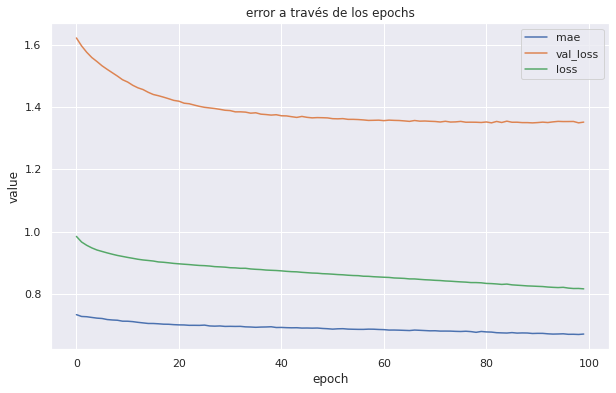

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4367875727031354
MAE is : 0.866445489059721
RMSE is : 1.1986607412871815
MAPE is : 42.17747368175457
Evaluation metric results:
MSE is : 1.331884344523511
MAE is : 0.9056116693210212
RMSE is : 1.154072937263287
MAPE is : 46.15365798608102
(637, 5, 5) (637, 1)
(271, 5, 5) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 29ms/step - loss: 0.9647 - mae: 0.7253 - val_loss: 1.4647 - val_mae: 0.8013
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9456 - mae: 0.7206 - val_loss: 1.4396 - val_mae: 0.7953
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9378 - mae: 0.7220 - val_loss: 1.4192 - val_mae: 0.7903
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9308 - mae: 0.7184 - val_loss: 1.4053 - val_mae: 0.7855
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9252 - mae: 0.7159 - val_loss:

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8433 - mae: 0.6855 - val_loss: 1.2732 - val_mae: 0.7661
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8422 - mae: 0.6842 - val_loss: 1.2688 - val_mae: 0.7666
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8413 - mae: 0.6827 - val_loss: 1.2716 - val_mae: 0.7641
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8386 - mae: 0.6830 - val_loss: 1.2698 - val_mae: 0.7659
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8384 - mae: 0.6823 - val_loss: 1.2688 - val_mae: 0.7662
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8365 - mae: 0.6814 - val_loss: 1.2655 - val_mae: 0.7658
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8341 - mae: 0.6805 - val_loss: 1.2620 - val_mae: 0.7655
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0.

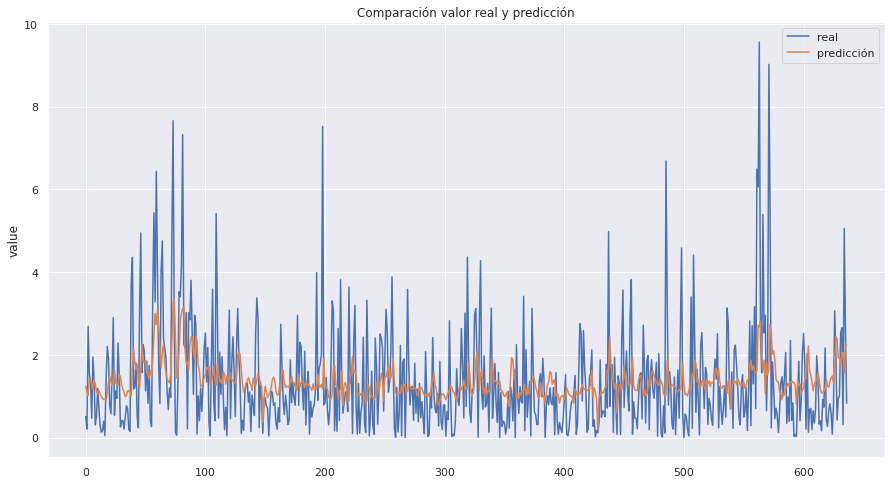

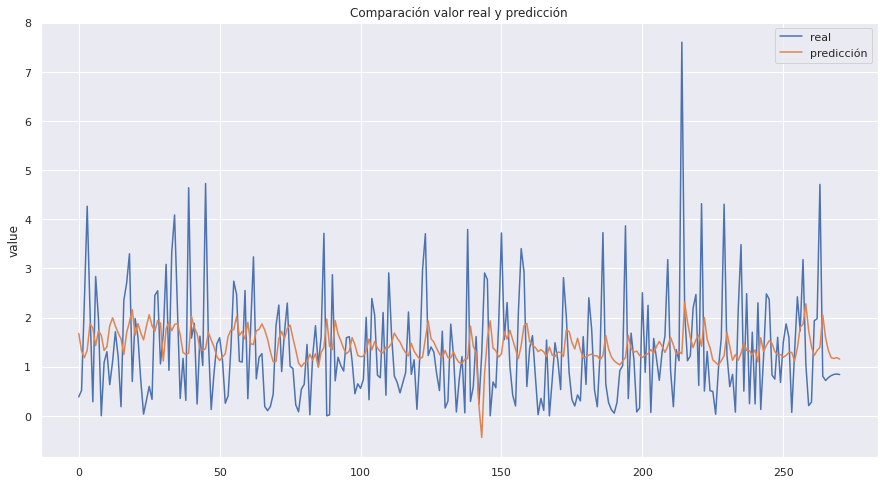

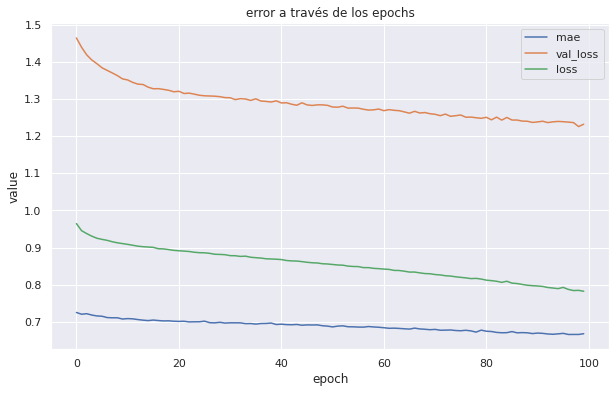

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3540805653809587
MAE is : 0.8575669825450899
RMSE is : 1.163649674679179
MAPE is : 42.148527474043604
Evaluation metric results:
MSE is : 1.341983773080956
MAE is : 0.8957442197197327
RMSE is : 1.158440232848012
MAPE is : 44.7945844704618
(637, 5, 5) (637, 1)
(271, 5, 5) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 25ms/step - loss: 0.9708 - mae: 0.7285 - val_loss: 1.4833 - val_mae: 0.7975
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9398 - mae: 0.7201 - val_loss: 1.4453 - val_mae: 0.7886
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9290 - mae: 0.7211 - val_loss: 1.4222 - val_mae: 0.7829
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9211 - mae: 0.7138 - val_loss: 1.4045 - val_mae: 0.7773
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9146 - mae: 0.7113 - val_loss:

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7938 - mae: 0.6732 - val_loss: 1.2836 - val_mae: 0.7856
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7928 - mae: 0.6724 - val_loss: 1.2779 - val_mae: 0.7874
Epoch 62/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7905 - mae: 0.6715 - val_loss: 1.2819 - val_mae: 0.7848
Epoch 63/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7847 - mae: 0.6705 - val_loss: 1.2836 - val_mae: 0.7897
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7859 - mae: 0.6710 - val_loss: 1.2829 - val_mae: 0.7916
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7818 - mae: 0.6688 - val_loss: 1.2752 - val_mae: 0.7900
Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7773 - mae: 0.6681 - val_loss: 1.2737 - val_mae: 0.7903
Epoch 67/100
32/32 [==============================] - 0s 10ms/step - loss:

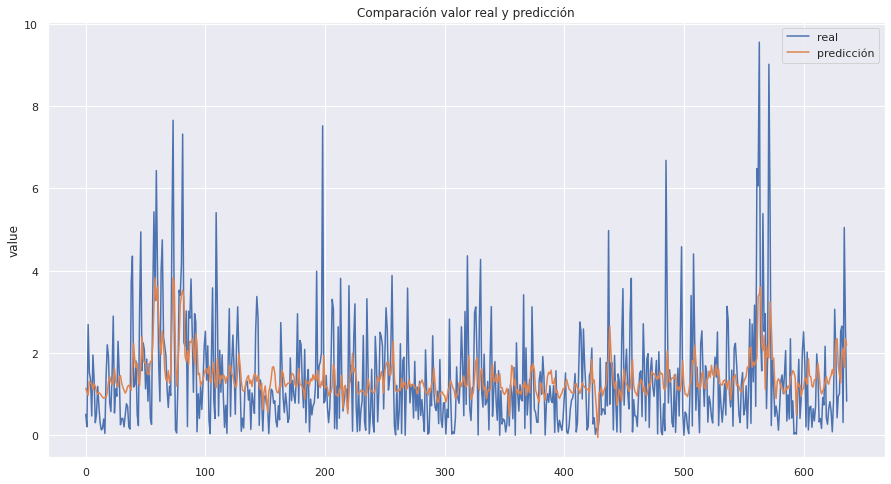

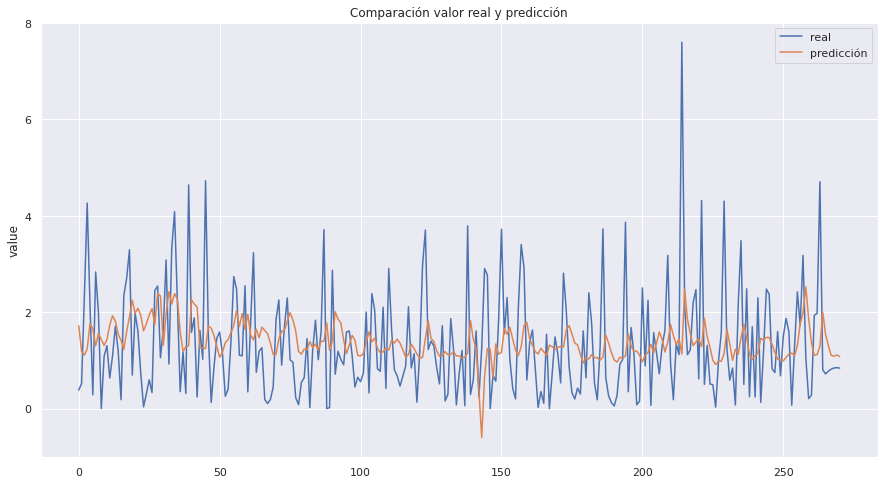

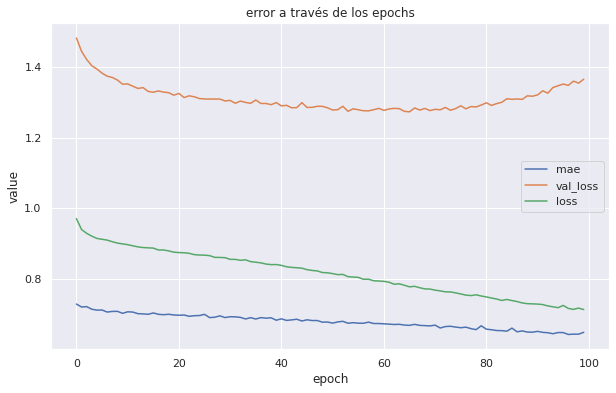

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3040765140068946
MAE is : 0.8490654041400864
RMSE is : 1.1419616955077323
MAPE is : 42.45274885439422
Evaluation metric results:
MSE is : 1.548840960999528
MAE is : 0.9361609614147093
RMSE is : 1.2445243914843647
MAPE is : 46.12419294133673
(637, 5, 5) (637, 1)
(271, 5, 5) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.9528 - mae: 0.7260 - val_loss: 1.4430 - val_mae: 0.7825
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9288 - mae: 0.7162 - val_loss: 1.4093 - val_mae: 0.7778
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9185 - mae: 0.7177 - val_loss: 1.3915 - val_mae: 0.7750
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9124 - mae: 0.7094 - val_loss: 1.3752 - val_mae: 0.7705
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9059 - mae: 0.7080 - val

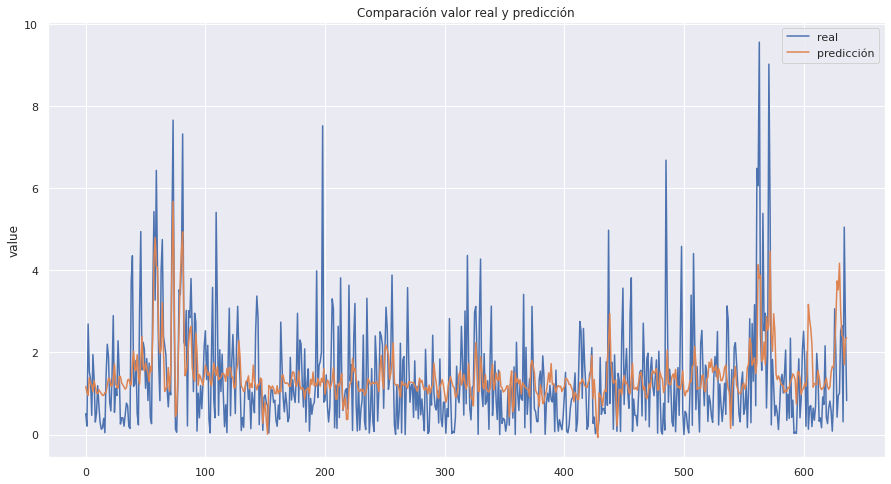

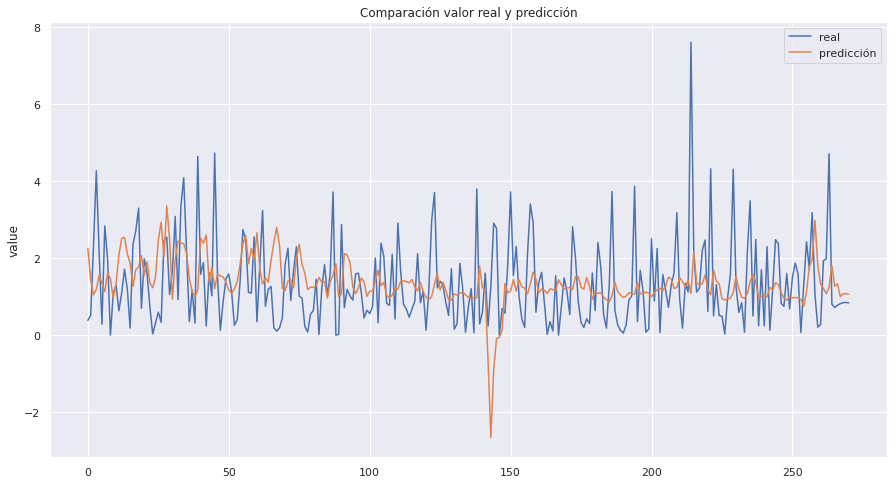

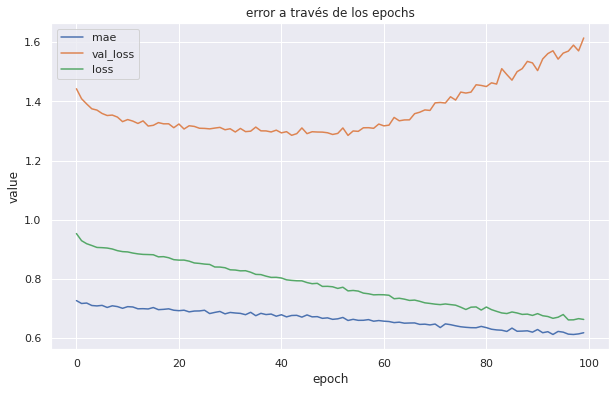

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.3141192384695797
MAE is : 0.8371683436491132
RMSE is : 1.1463503995156017
MAPE is : 42.071017200653436
Evaluation metric results:
MSE is : 1.740366127869068
MAE is : 0.9739043046803213
RMSE is : 1.3192293689381949
MAPE is : 49.48309196310775
(637, 5, 5) (637, 1)
(271, 5, 5) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 39ms/step - loss: 0.9515 - mae: 0.7299 - val_loss: 1.4118 - val_mae: 0.7833
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9293 - mae: 0.7163 - val_loss: 1.3762 - val_mae: 0.7792
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9168 - mae: 0.7208 - val_loss: 1.3676 - val_mae: 0.7795
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9107 - mae: 0.7106 - val_loss: 1.3517 - val_mae: 0.7727
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9025 - mae: 0.7091 - va

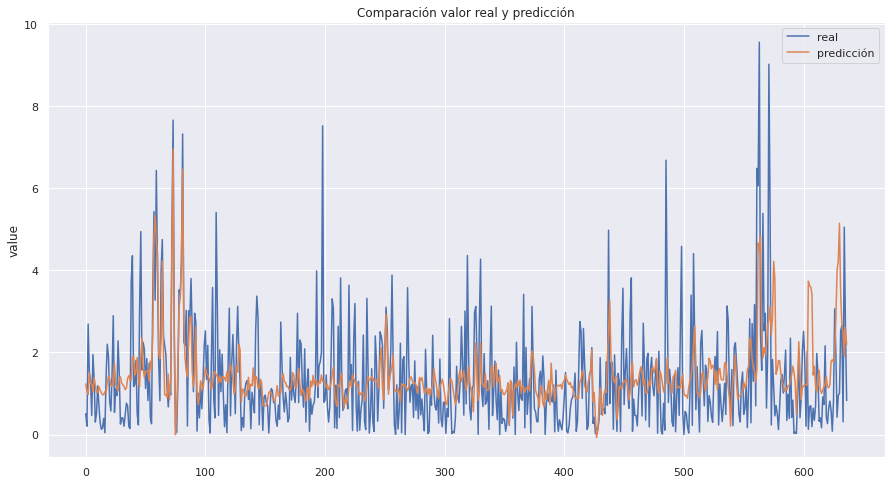

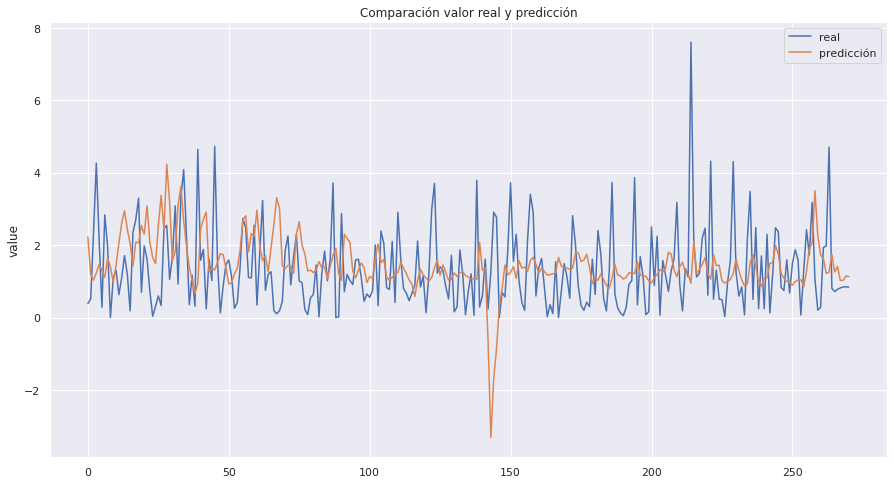

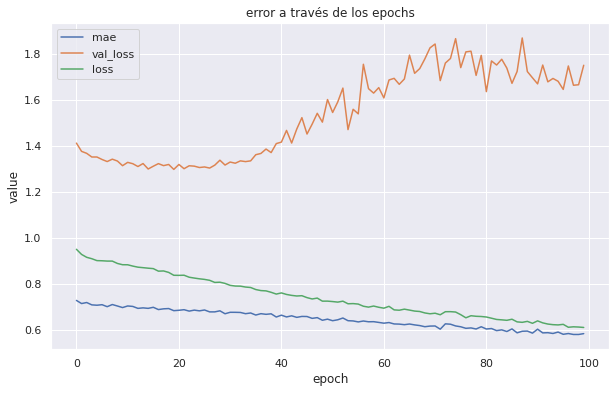

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.2892790477302873
MAE is : 0.8085026672940242
RMSE is : 1.1354642432636473
MAPE is : 40.569619465005076
Evaluation metric results:
MSE is : 2.0116652302885116
MAE is : 1.0049009763526155
RMSE is : 1.4183318477311688
MAPE is : 49.10129981268424
(637, 5, 5) (637, 1)
(271, 5, 5) (271, 1)
Epoch 1/100
32/32 [==============================] - 5s 53ms/step - loss: 0.9627 - mae: 0.7340 - val_loss: 1.4041 - val_mae: 0.7838
Epoch 2/100
32/32 [==============================] - 1s 32ms/step - loss: 0.9287 - mae: 0.7163 - val_loss: 1.3639 - val_mae: 0.7767
Epoch 3/100
32/32 [==============================] - 1s 33ms/step - loss: 0.9166 - mae: 0.7230 - val_loss: 1.3605 - val_mae: 0.7783
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 0.9105 - mae: 0.7111 - val_loss: 1.3443 - val_mae: 0.7685
Epoch 5/100
32/32 [==============================] - 1s 31ms/step - loss: 0.9005 - mae: 0.7091 - v

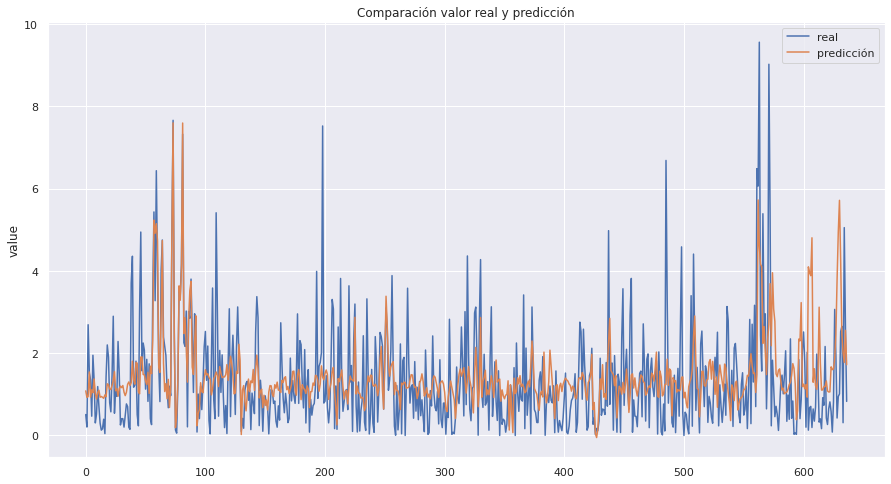

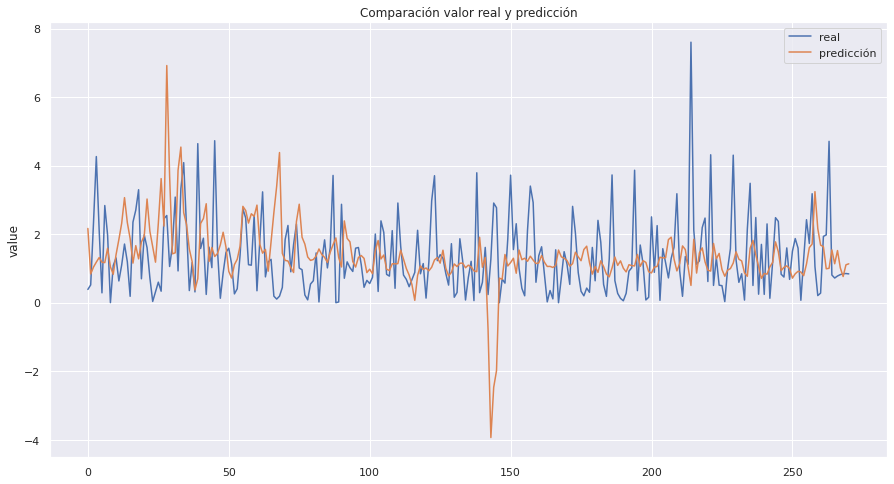

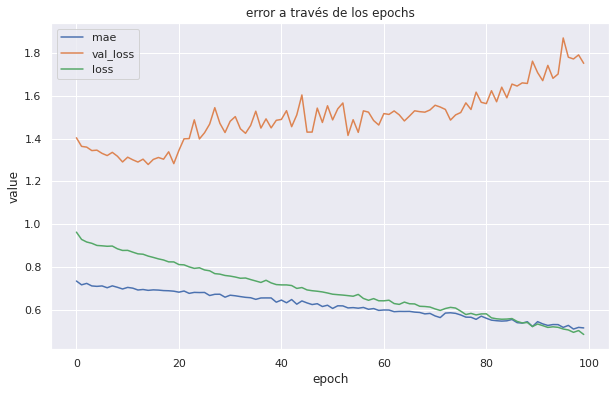

9/9 [==============================] - 0s 10ms/step
Evaluation metric results:
MSE is : 1.139980321284012
MAE is : 0.7318288897873929
RMSE is : 1.0676986097602694
MAPE is : 34.56758429341499
Evaluation metric results:
MSE is : 2.0363536866004863
MAE is : 1.0284794226127654
RMSE is : 1.4270086497987622
MAPE is : 48.74621683588342
(634, 8, 5) (634, 1)
(268, 8, 5) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 30ms/step - loss: 0.9789 - mae: 0.7373 - val_loss: 1.4280 - val_mae: 0.8075
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9560 - mae: 0.7272 - val_loss: 1.4226 - val_mae: 0.7991
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9444 - mae: 0.7228 - val_loss: 1.4189 - val_mae: 0.7954
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9365 - mae: 0.7185 - val_loss: 1.4147 - val_mae: 0.7914
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9316 - mae: 0.7168 - val

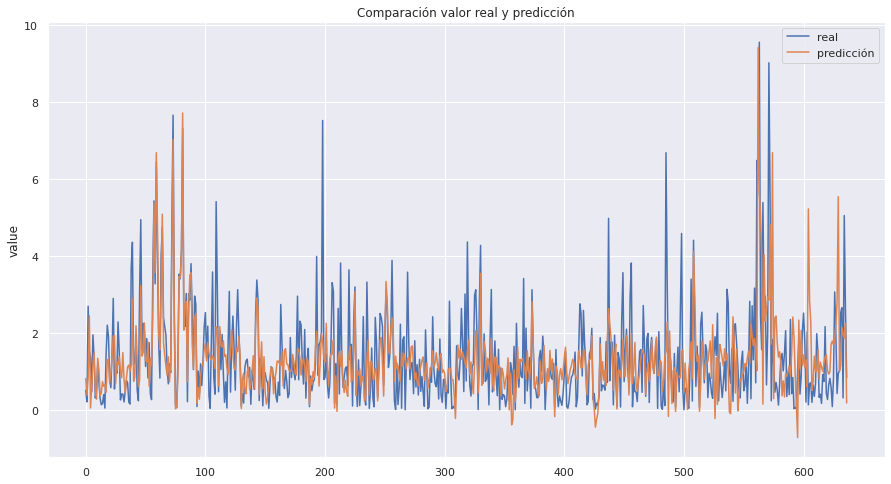

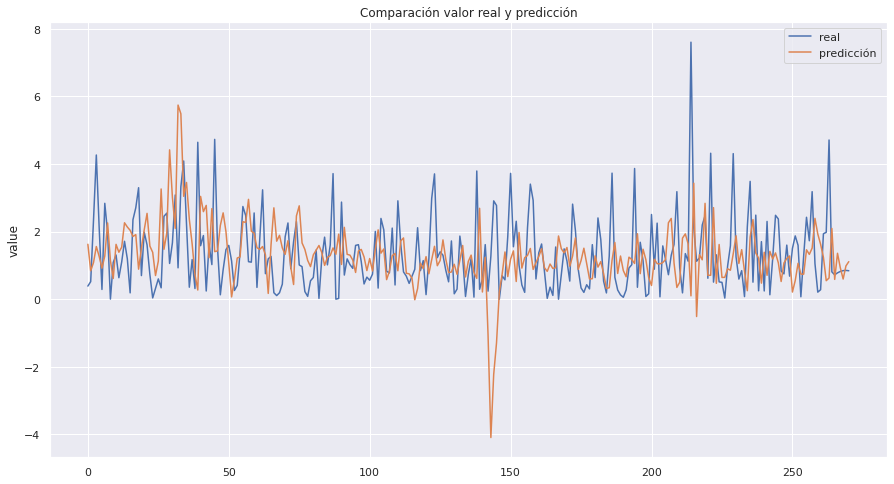

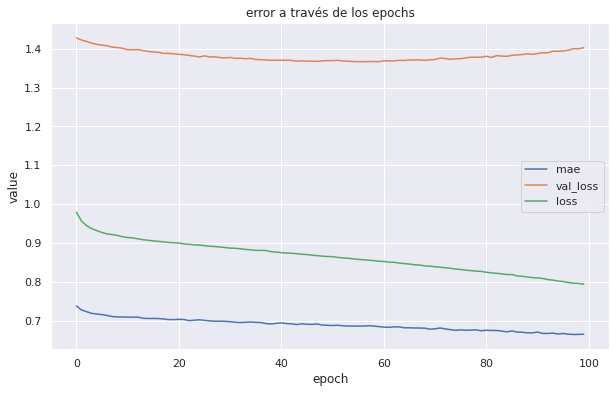

9/9 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.4219569856922745
MAE is : 0.8691075372683261
RMSE is : 1.1924583790188548
MAPE is : 42.67941229729757
Evaluation metric results:
MSE is : 1.3270074597767683
MAE is : 0.8875014878501297
RMSE is : 1.151958098099392
MAPE is : 44.877556094306556
(634, 8, 5) (634, 1)
(268, 8, 5) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 31ms/step - loss: 0.9686 - mae: 0.7384 - val_loss: 1.4869 - val_mae: 0.8032
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9377 - mae: 0.7235 - val_loss: 1.4586 - val_mae: 0.7960
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9245 - mae: 0.7195 - val_loss: 1.4368 - val_mae: 0.7942
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9150 - mae: 0.7130 - val_loss: 1.4145 - val_mae: 0.7900
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9100 - mae: 0.7122 - va

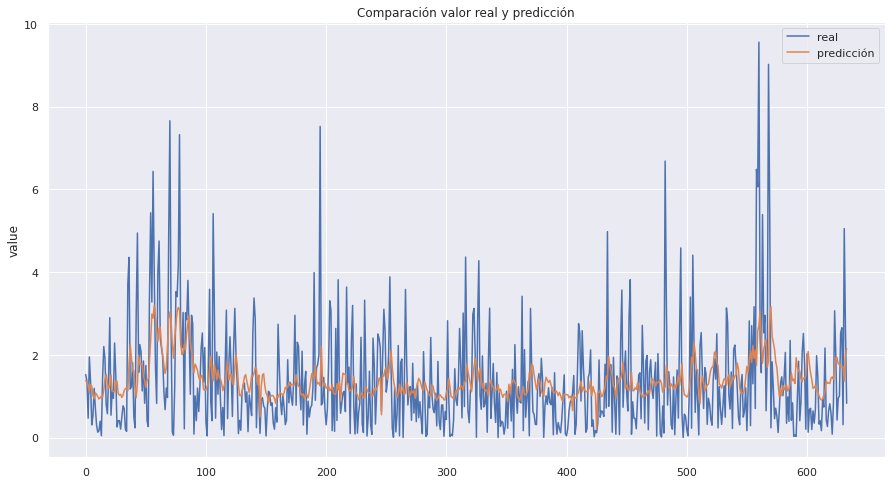

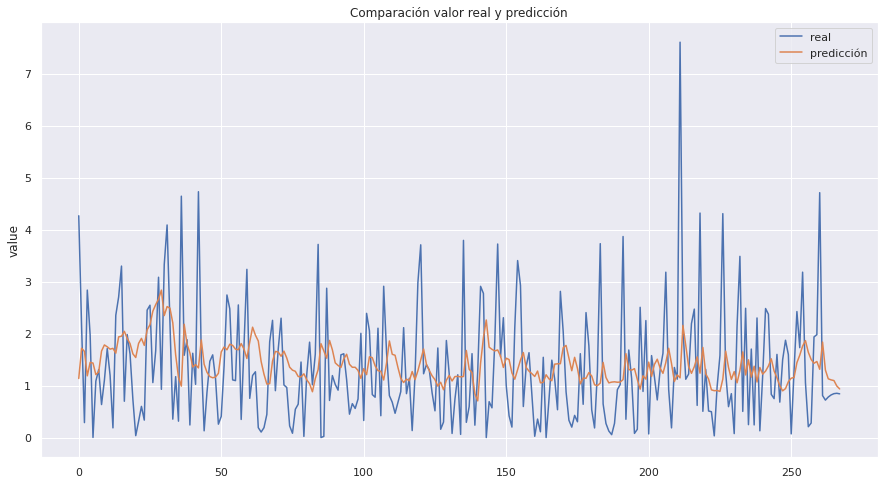

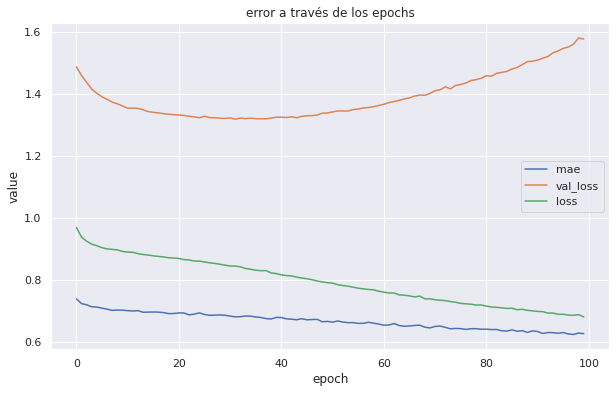

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3320134788109363
MAE is : 0.8449296432992586
RMSE is : 1.1541288831022887
MAPE is : 41.56172060979952
Evaluation metric results:
MSE is : 1.3653929656187587
MAE is : 0.896600476956205
RMSE is : 1.1685003062125223
MAPE is : 44.72429561264375
(634, 8, 5) (634, 1)
(268, 8, 5) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.9782 - mae: 0.7371 - val_loss: 1.4930 - val_mae: 0.7967
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9430 - mae: 0.7204 - val_loss: 1.4573 - val_mae: 0.7868
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9292 - mae: 0.7168 - val_loss: 1.4333 - val_mae: 0.7836
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9200 - mae: 0.7094 - val_loss: 1.4087 - val_mae: 0.7799
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9160 - mae: 0.7102 - val

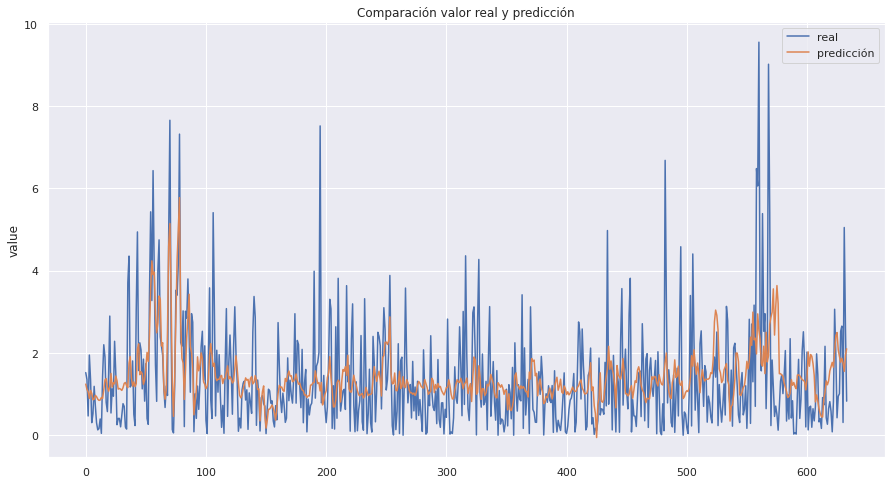

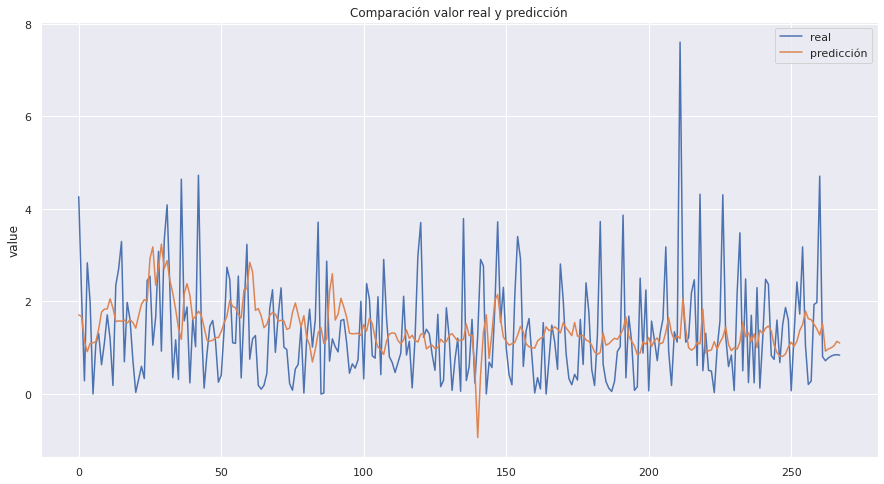

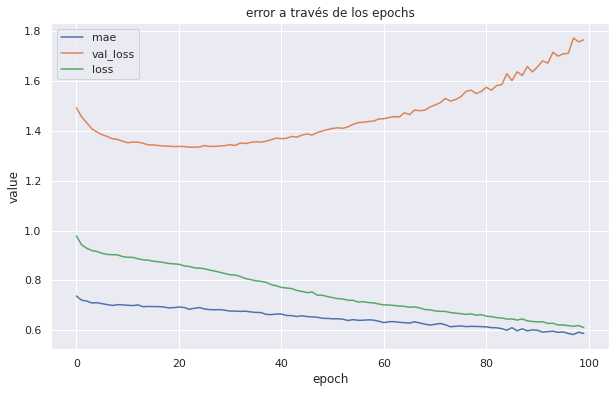

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.2984759678797948
MAE is : 0.8207839253390087
RMSE is : 1.1395068968109823
MAPE is : 41.29336563200519
Evaluation metric results:
MSE is : 1.610381741834863
MAE is : 0.9520985748916531
RMSE is : 1.2690081724854505
MAPE is : 47.277865501551126
(634, 8, 5) (634, 1)
(268, 8, 5) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 42ms/step - loss: 0.9621 - mae: 0.7311 - val_loss: 1.4654 - val_mae: 0.7902
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9198 - mae: 0.7114 - val_loss: 1.4176 - val_mae: 0.7792
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9117 - mae: 0.7085 - val_loss: 1.3999 - val_mae: 0.7795
Epoch 4/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9029 - mae: 0.7022 - val_loss: 1.3781 - val_mae: 0.7775
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.9015 - mae: 0.7057 - va

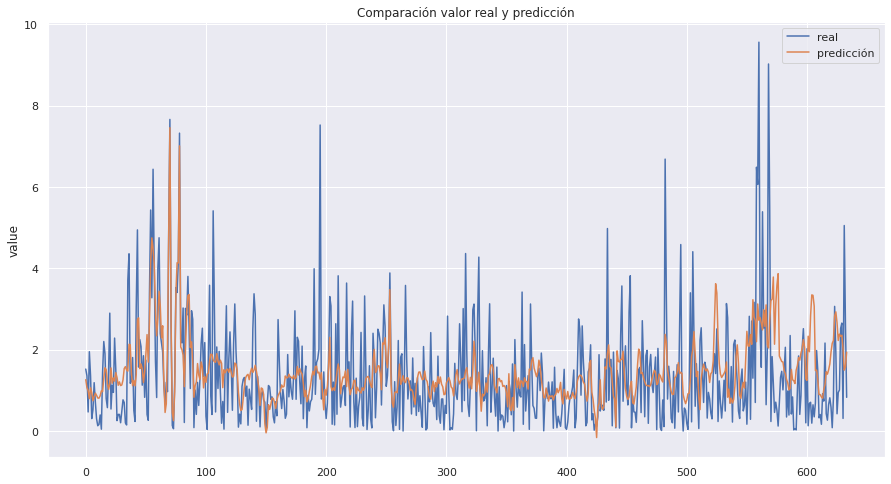

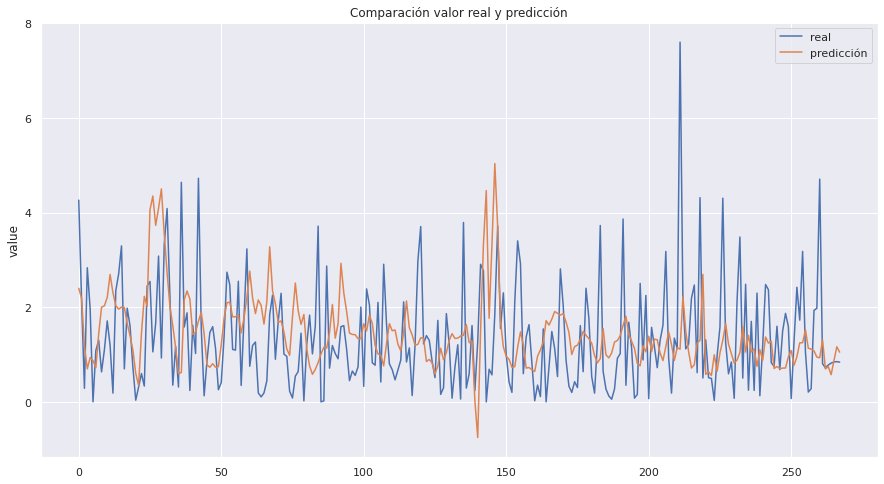

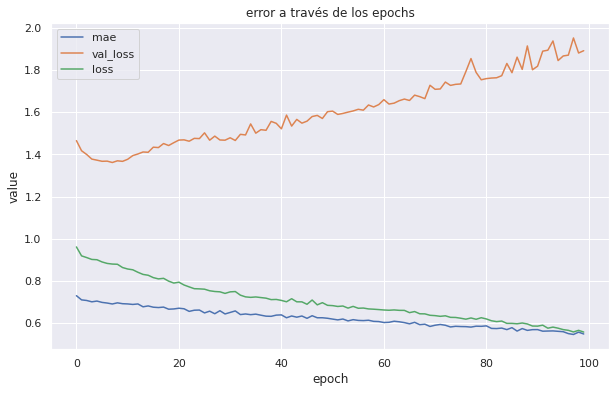

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.262035844005284
MAE is : 0.7929842659267791
RMSE is : 1.123403687017843
MAPE is : 39.93862220872709
Evaluation metric results:
MSE is : 1.654018441019308
MAE is : 0.9484528714903454
RMSE is : 1.28608648271386
MAPE is : 44.35432126200266
(634, 8, 5) (634, 1)
(268, 8, 5) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 42ms/step - loss: 0.9532 - mae: 0.7253 - val_loss: 1.3772 - val_mae: 0.7757
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9101 - mae: 0.7048 - val_loss: 1.3531 - val_mae: 0.7738
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9044 - mae: 0.7036 - val_loss: 1.3568 - val_mae: 0.7769
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8943 - mae: 0.6984 - val_loss: 1.3341 - val_mae: 0.7822
Epoch 5/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8942 - mae: 0.7055 - val_los

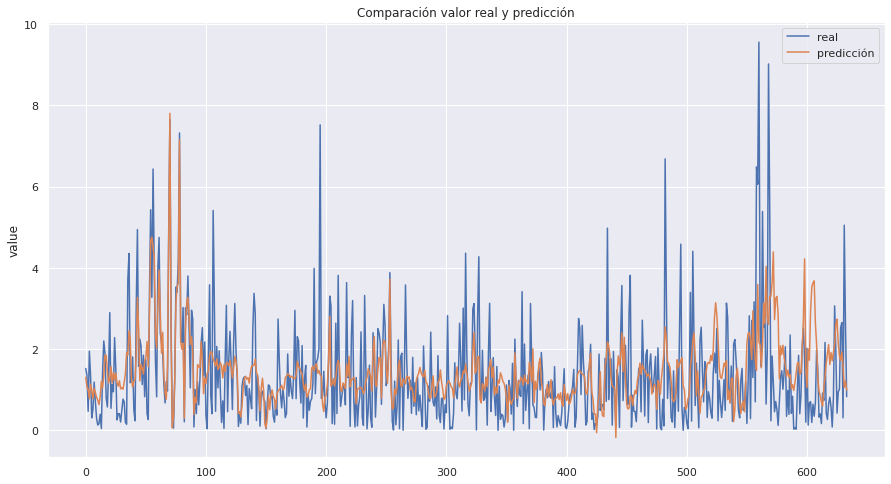

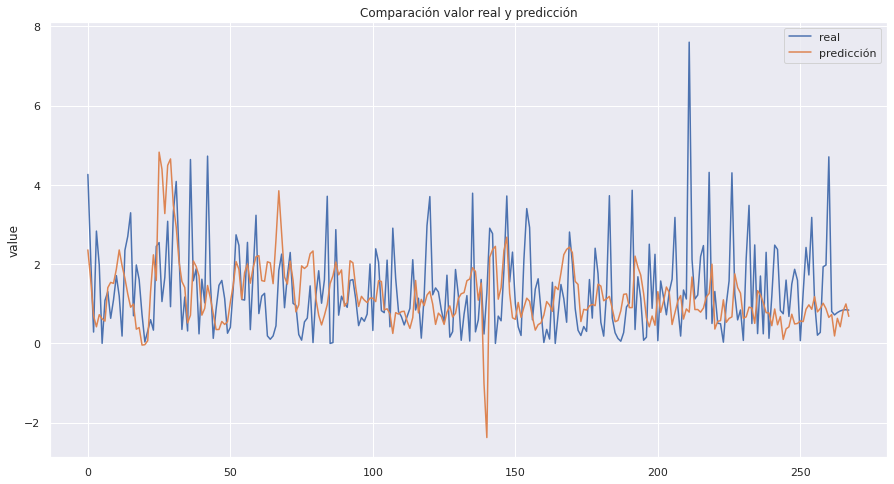

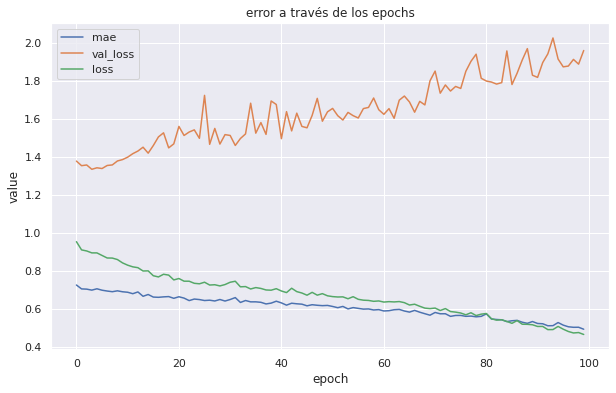

9/9 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 1.1589190404691965
MAE is : 0.7534594148785643
RMSE is : 1.0765310216009554
MAPE is : 38.62259360124109
Evaluation metric results:
MSE is : 1.8084132890576594
MAE is : 0.9887360676712416
RMSE is : 1.3447725789358063
MAPE is : 48.395157108414054
(634, 8, 5) (634, 1)
(268, 8, 5) (268, 1)
Epoch 1/100
32/32 [==============================] - 6s 88ms/step - loss: 0.9860 - mae: 0.7375 - val_loss: 1.3821 - val_mae: 0.7782
Epoch 2/100
32/32 [==============================] - 2s 54ms/step - loss: 0.9091 - mae: 0.7056 - val_loss: 1.3499 - val_mae: 0.7736
Epoch 3/100
32/32 [==============================] - 2s 58ms/step - loss: 0.8994 - mae: 0.7039 - val_loss: 1.3496 - val_mae: 0.7772
Epoch 4/100
32/32 [==============================] - 2s 57ms/step - loss: 0.8827 - mae: 0.6976 - val_loss: 1.3341 - val_mae: 0.7850
Epoch 5/100
32/32 [==============================] - 2s 54ms/step - loss: 0.8791 - mae: 0.7031 - v

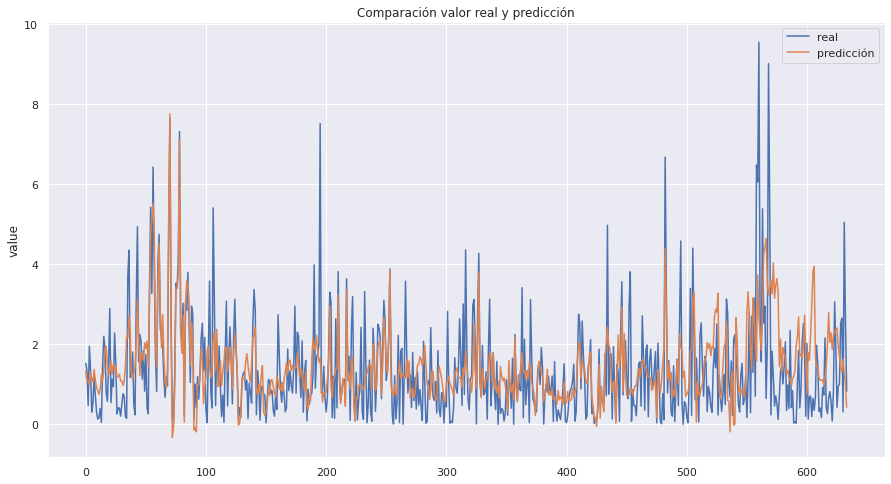

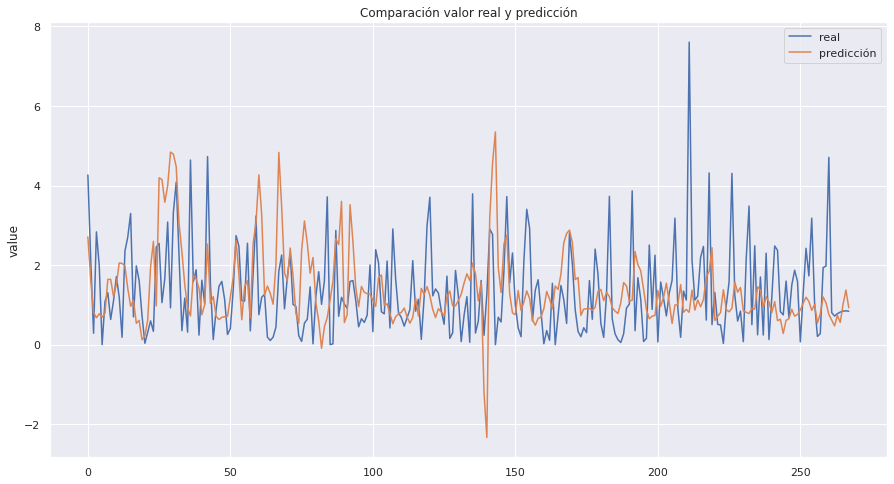

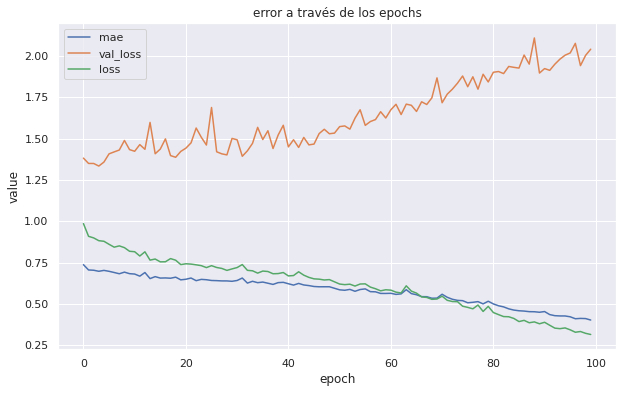

9/9 [==============================] - 0s 17ms/step
Evaluation metric results:
MSE is : 0.9966018361377876
MAE is : 0.6579617276342181
RMSE is : 0.998299472171446
MAPE is : 32.21015154097973
Evaluation metric results:
MSE is : 1.9674382879447379
MAE is : 1.002398008415333
RMSE is : 1.4026540157660896
MAPE is : 48.39439660701938
(632, 10, 5) (632, 1)
(266, 10, 5) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 1.0190 - mae: 0.7502 - val_loss: 1.4880 - val_mae: 0.8007
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9787 - mae: 0.7383 - val_loss: 1.4631 - val_mae: 0.7984
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9597 - mae: 0.7320 - val_loss: 1.4435 - val_mae: 0.7932
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9460 - mae: 0.7244 - val_loss: 1.4302 - val_mae: 0.7903
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9358 - mae: 0.7195 - v

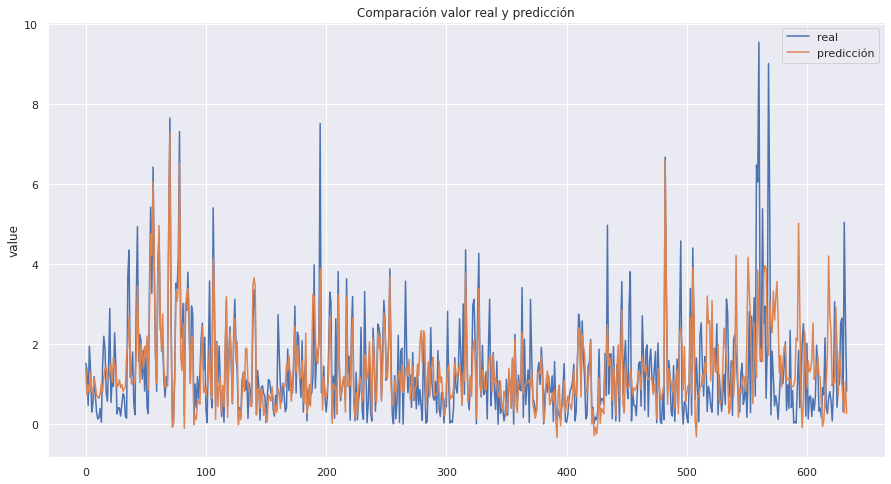

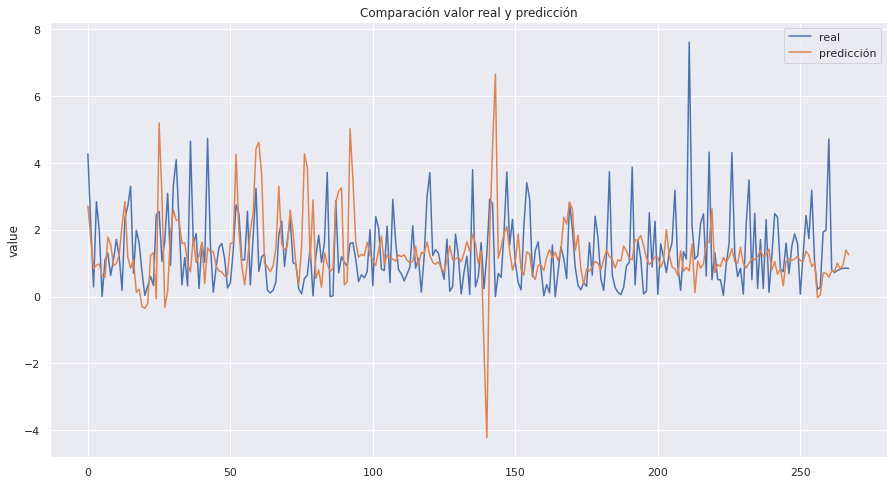

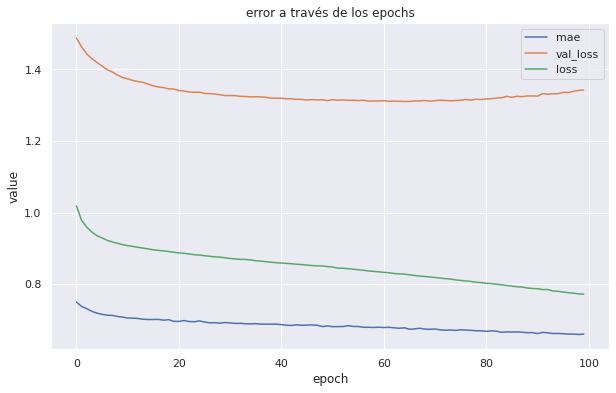

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3769658151265327
MAE is : 0.8585769928554658
RMSE is : 1.1734418669565752
MAPE is : 42.27971436597585
Evaluation metric results:
MSE is : 1.3232321633470459
MAE is : 0.878089541366428
RMSE is : 1.1503182878434324
MAPE is : 43.029731112558814
(632, 10, 5) (632, 1)
(266, 10, 5) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 37ms/step - loss: 0.9994 - mae: 0.7404 - val_loss: 1.6303 - val_mae: 0.8164
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9687 - mae: 0.7301 - val_loss: 1.5816 - val_mae: 0.8096
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9526 - mae: 0.7261 - val_loss: 1.5450 - val_mae: 0.7992
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9410 - mae: 0.7193 - val_loss: 1.5178 - val_mae: 0.7932
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9313 - mae: 0.7156 - 

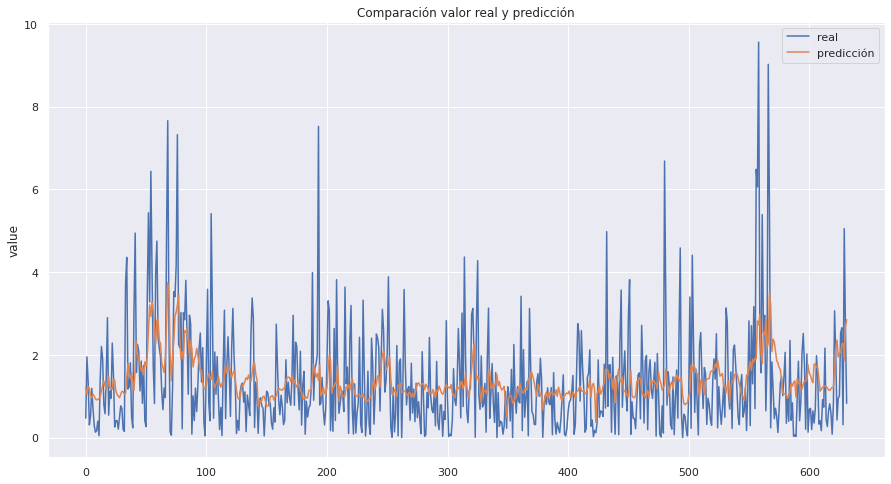

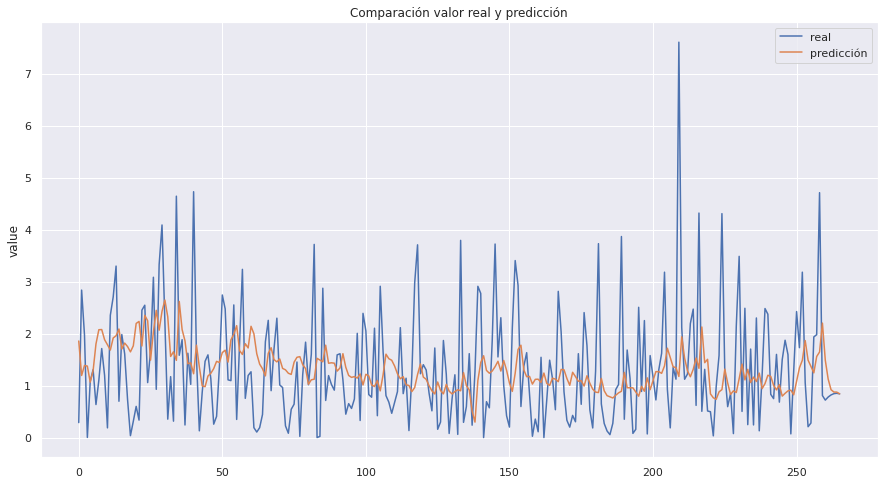

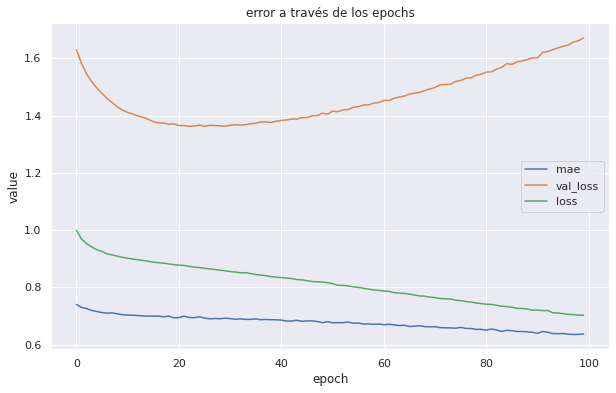

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3865054005806177
MAE is : 0.8470121207506968
RMSE is : 1.177499639312309
MAPE is : 40.9846843515775
Evaluation metric results:
MSE is : 1.4223225100944779
MAE is : 0.8889029756488966
RMSE is : 1.1926116342273698
MAPE is : 43.3518523627675
(632, 10, 5) (632, 1)
(266, 10, 5) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 37ms/step - loss: 0.9681 - mae: 0.7236 - val_loss: 1.4779 - val_mae: 0.7831
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9322 - mae: 0.7192 - val_loss: 1.4247 - val_mae: 0.7814
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9199 - mae: 0.7156 - val_loss: 1.3954 - val_mae: 0.7745
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9146 - mae: 0.7086 - val_loss: 1.3816 - val_mae: 0.7730
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9054 - mae: 0.7060 - val

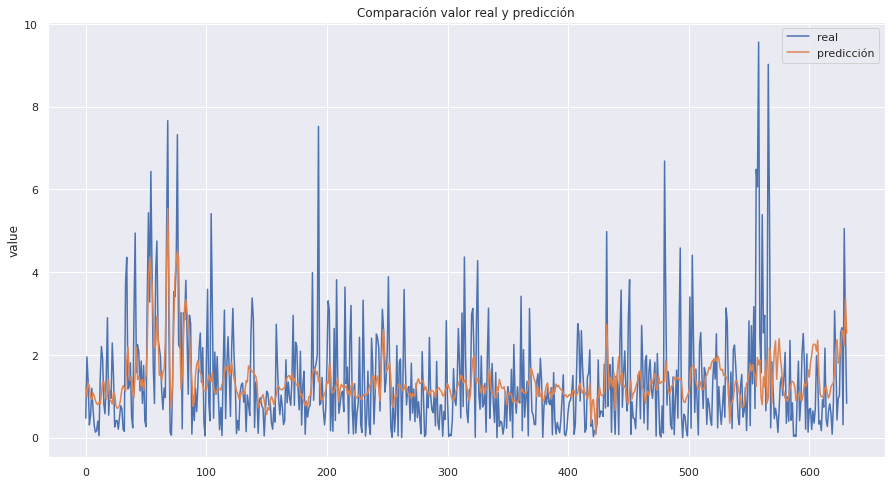

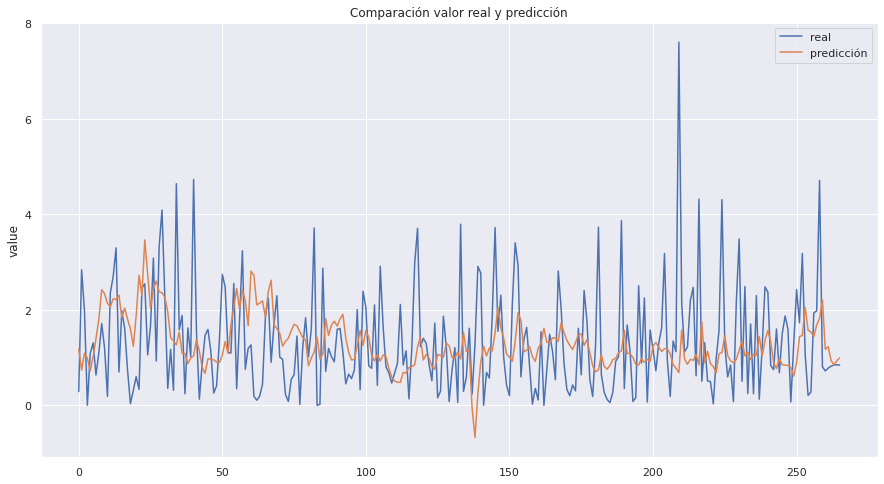

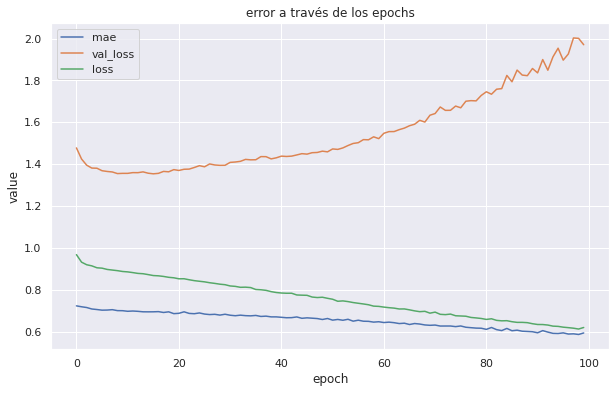

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.3700131274146188
MAE is : 0.8290348714784044
RMSE is : 1.1704755988121318
MAPE is : 40.561664852047755
Evaluation metric results:
MSE is : 1.7234984079304254
MAE is : 0.9729384739775381
RMSE is : 1.3128207828681056
MAPE is : 46.761680424386995
(632, 10, 5) (632, 1)
(266, 10, 5) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 40ms/step - loss: 0.9512 - mae: 0.7135 - val_loss: 1.3904 - val_mae: 0.7734
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.9196 - mae: 0.7149 - val_loss: 1.3609 - val_mae: 0.7793
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9116 - mae: 0.7125 - val_loss: 1.3436 - val_mae: 0.7762
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9106 - mae: 0.7053 - val_loss: 1.3454 - val_mae: 0.7742
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.8995 - mae: 0.7062 

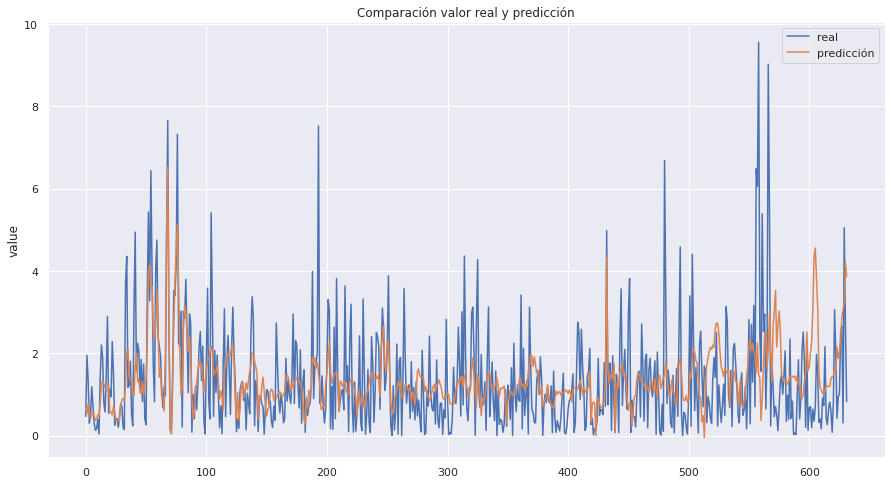

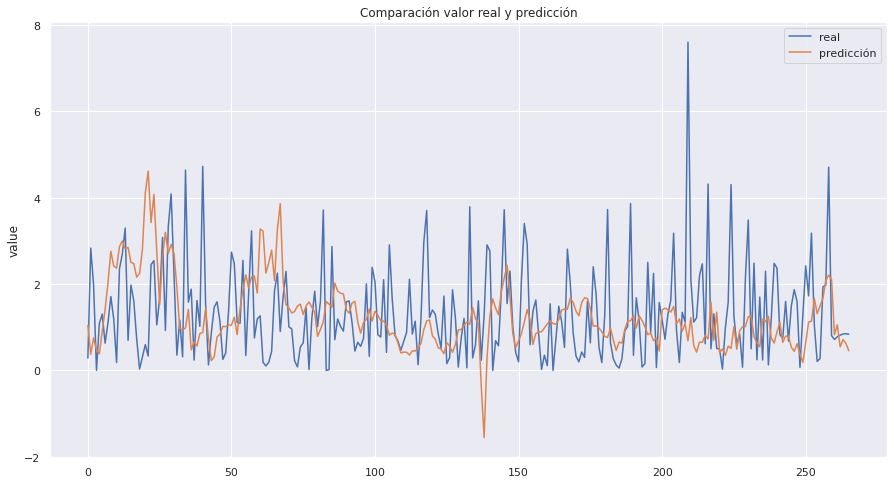

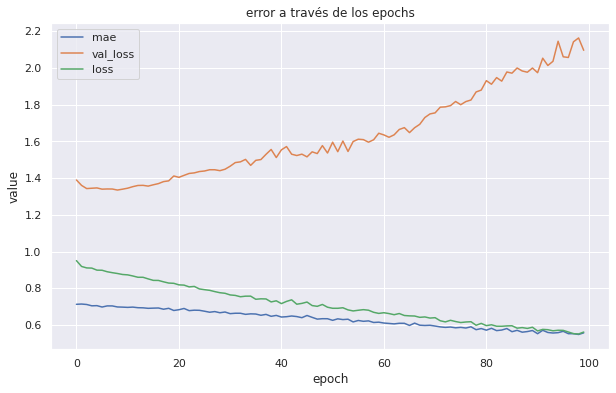

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.3318223902664152
MAE is : 0.7943565096259422
RMSE is : 1.154046095381989
MAPE is : 38.61897190154145
Evaluation metric results:
MSE is : 1.668629807323064
MAE is : 0.9753176878972611
RMSE is : 1.2917545460818258
MAPE is : 44.921598414423144
(632, 10, 5) (632, 1)
(266, 10, 5) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 40ms/step - loss: 0.9591 - mae: 0.7145 - val_loss: 1.3739 - val_mae: 0.7672
Epoch 2/100
32/32 [==============================] - 1s 21ms/step - loss: 0.9219 - mae: 0.7137 - val_loss: 1.3545 - val_mae: 0.7775
Epoch 3/100
32/32 [==============================] - 1s 21ms/step - loss: 0.9083 - mae: 0.7098 - val_loss: 1.3354 - val_mae: 0.7782
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9106 - mae: 0.7051 - val_loss: 1.3517 - val_mae: 0.7726
Epoch 5/100
32/32 [==============================] - 1s 23ms/step - loss: 0.8949 - mae: 0.7048 - v

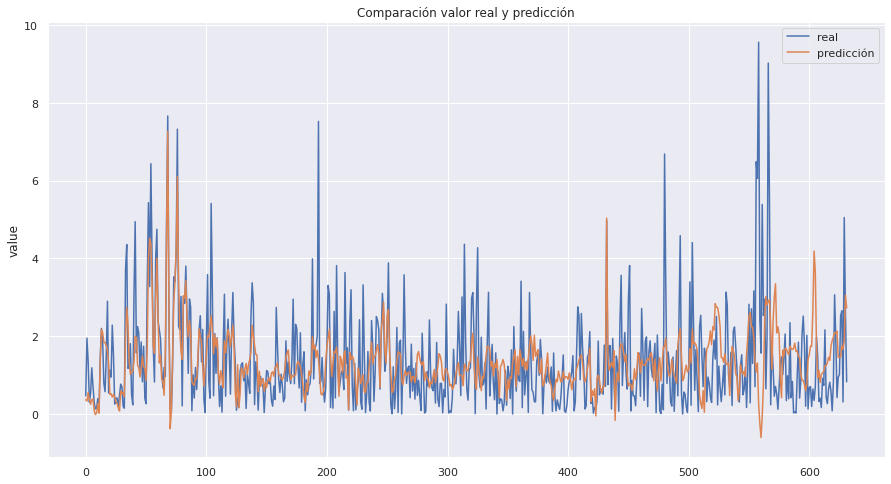

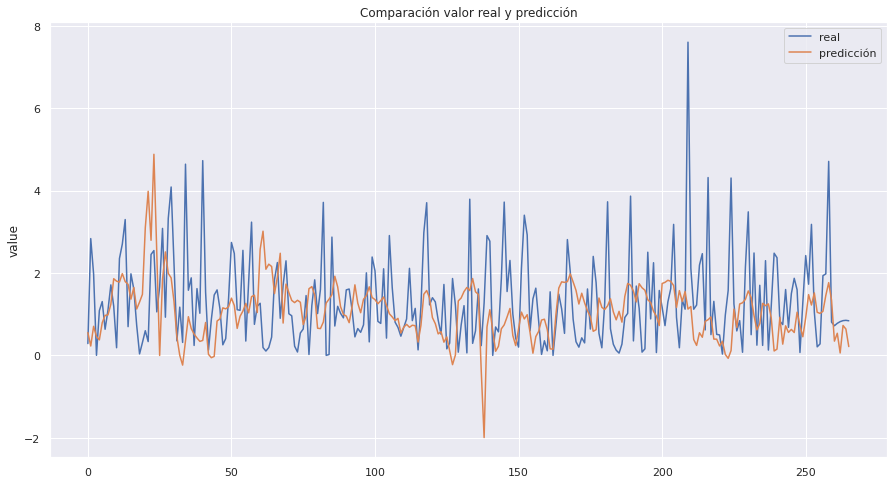

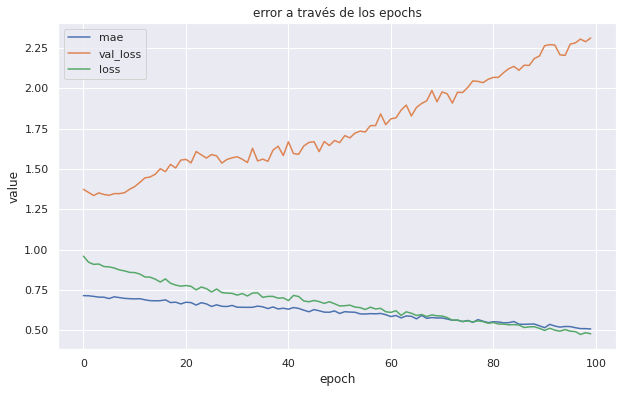

9/9 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 1.2826034859871598
MAE is : 0.7487925024282407
RMSE is : 1.1325208545484537
MAPE is : 36.20088629279985
Evaluation metric results:
MSE is : 1.8428812886144645
MAE is : 1.0142734189907332
RMSE is : 1.3575276382506782
MAPE is : 46.905525186014366
(632, 10, 5) (632, 1)
(266, 10, 5) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 78ms/step - loss: 0.9699 - mae: 0.7233 - val_loss: 1.3750 - val_mae: 0.7695
Epoch 2/100
32/32 [==============================] - 2s 52ms/step - loss: 0.9187 - mae: 0.7118 - val_loss: 1.3365 - val_mae: 0.7827
Epoch 3/100
32/32 [==============================] - 2s 55ms/step - loss: 0.9019 - mae: 0.7104 - val_loss: 1.3205 - val_mae: 0.7911
Epoch 4/100
32/32 [==============================] - 2s 54ms/step - loss: 0.8976 - mae: 0.7071 - val_loss: 1.3528 - val_mae: 0.7731
Epoch 5/100
32/32 [==============================] - 2s 57ms/step - loss: 0.8834 - mae: 0.7063 -

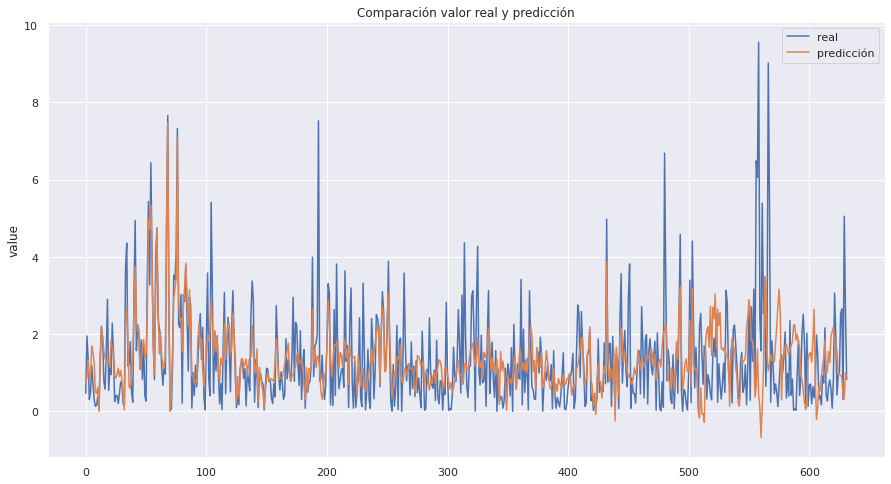

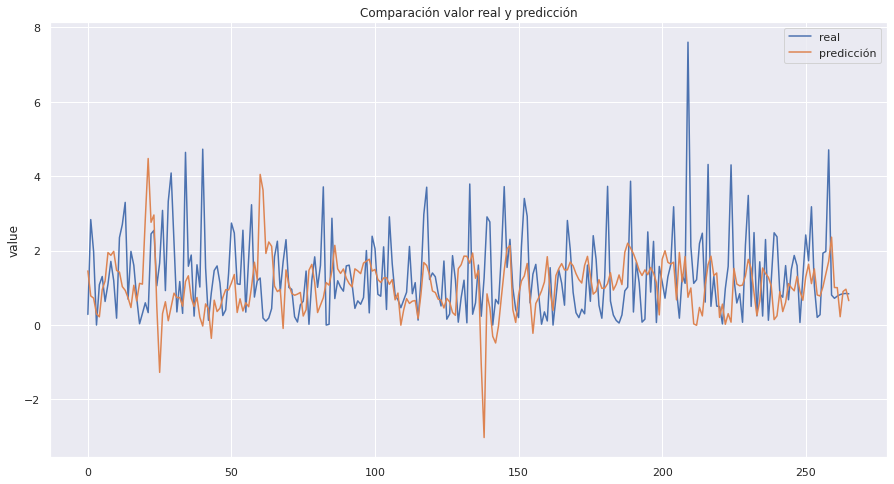

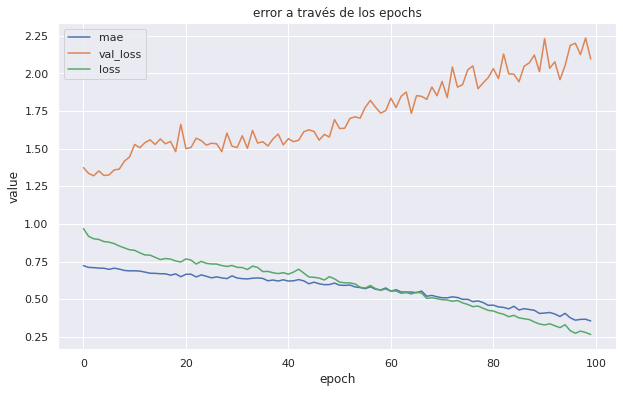

9/9 [==============================] - 0s 20ms/step
Evaluation metric results:
MSE is : 0.9803638210521913
MAE is : 0.6067965893864807
RMSE is : 0.9901332339903511
MAPE is : 29.613402620047623
Evaluation metric results:
MSE is : 2.065425414197827
MAE is : 1.0498620663986429
RMSE is : 1.4371587992277775
MAPE is : 49.04329779151679
(627, 15, 5) (627, 1)
(261, 15, 5) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 38ms/step - loss: 0.9994 - mae: 0.7570 - val_loss: 1.4275 - val_mae: 0.7784
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9523 - mae: 0.7235 - val_loss: 1.4134 - val_mae: 0.7734
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9379 - mae: 0.7172 - val_loss: 1.3995 - val_mae: 0.7737
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9290 - mae: 0.7126 - val_loss: 1.3893 - val_mae: 0.7716
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9239 - mae: 0.7084 -

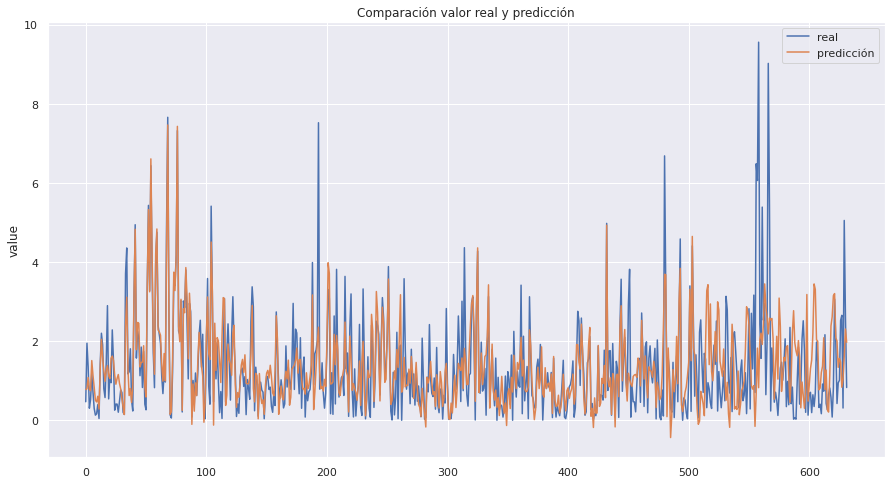

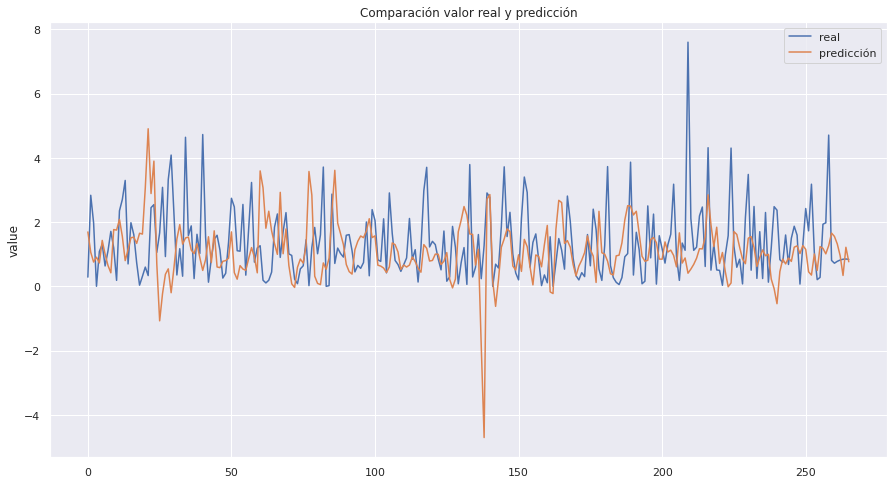

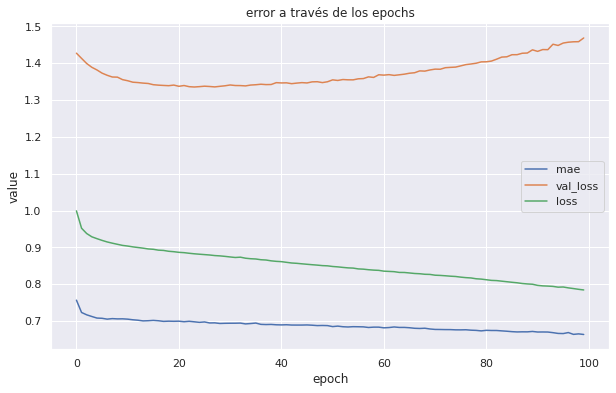

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4334376210471207
MAE is : 0.8541304794375364
RMSE is : 1.197262553096488
MAPE is : 40.86497007927071
Evaluation metric results:
MSE is : 1.3009311231115723
MAE is : 0.872111637886087
RMSE is : 1.1405836765058373
MAPE is : 44.190512784636724
(627, 15, 5) (627, 1)
(261, 15, 5) (261, 1)
Epoch 1/100
32/32 [==============================] - 3s 30ms/step - loss: 0.9581 - mae: 0.7393 - val_loss: 1.4427 - val_mae: 0.7805
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9353 - mae: 0.7118 - val_loss: 1.4173 - val_mae: 0.7727
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9256 - mae: 0.7148 - val_loss: 1.3993 - val_mae: 0.7734
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9180 - mae: 0.7109 - val_loss: 1.3821 - val_mae: 0.7690
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9148 - mae: 0.7057 - v

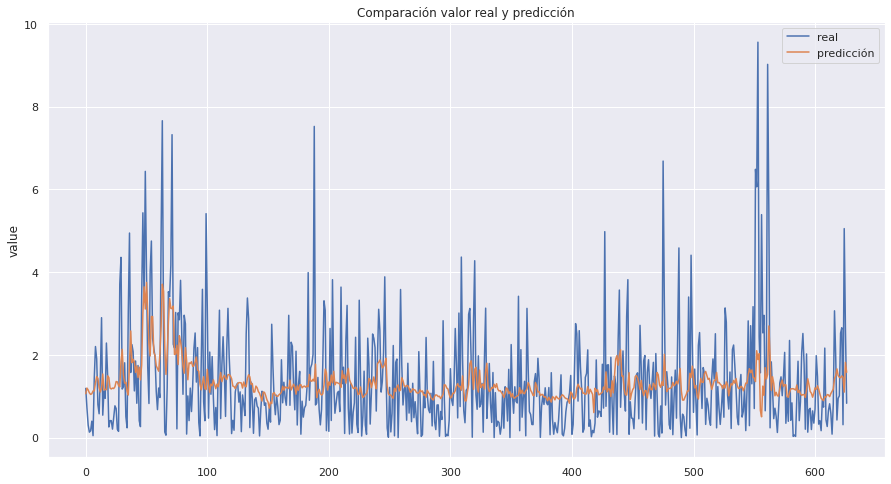

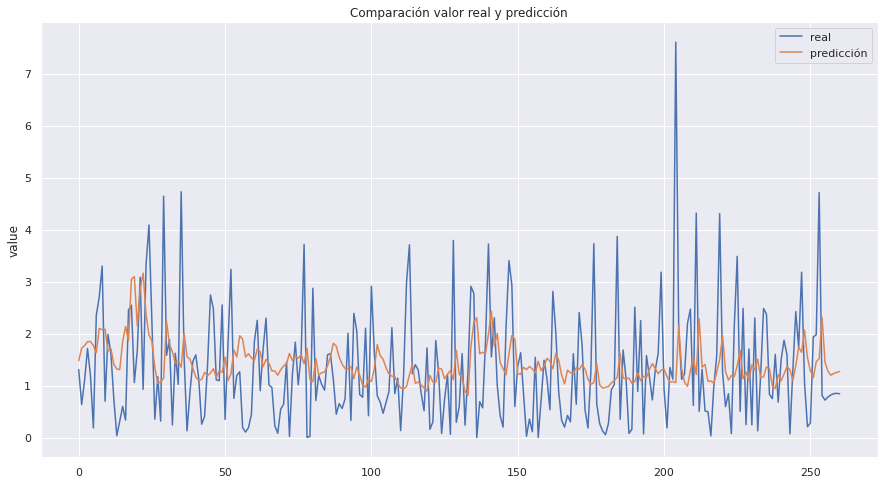

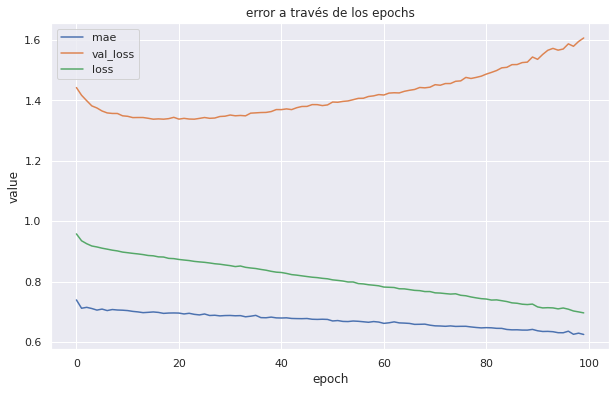

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.361986228827578
MAE is : 0.8305457868366644
RMSE is : 1.1670416568518787
MAPE is : 39.88545801749631
Evaluation metric results:
MSE is : 1.7016433450804114
MAE is : 0.984422837952661
RMSE is : 1.3044705228867426
MAPE is : 48.80557915426278
(627, 15, 5) (627, 1)
(261, 15, 5) (261, 1)
Epoch 1/100
32/32 [==============================] - 3s 31ms/step - loss: 0.9584 - mae: 0.7343 - val_loss: 1.4342 - val_mae: 0.7913
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9238 - mae: 0.7039 - val_loss: 1.4057 - val_mae: 0.7804
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9113 - mae: 0.7118 - val_loss: 1.3875 - val_mae: 0.7808
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9055 - mae: 0.7056 - val_loss: 1.3790 - val_mae: 0.7788
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9004 - mae: 0.7008 - va

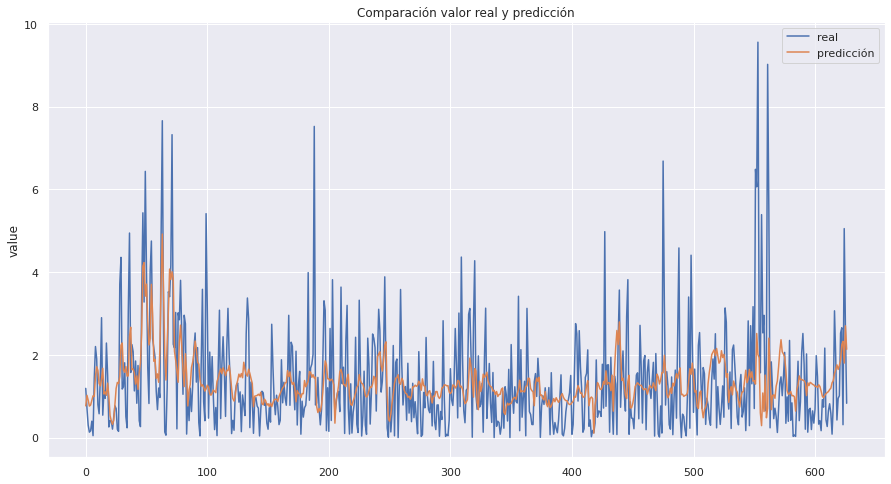

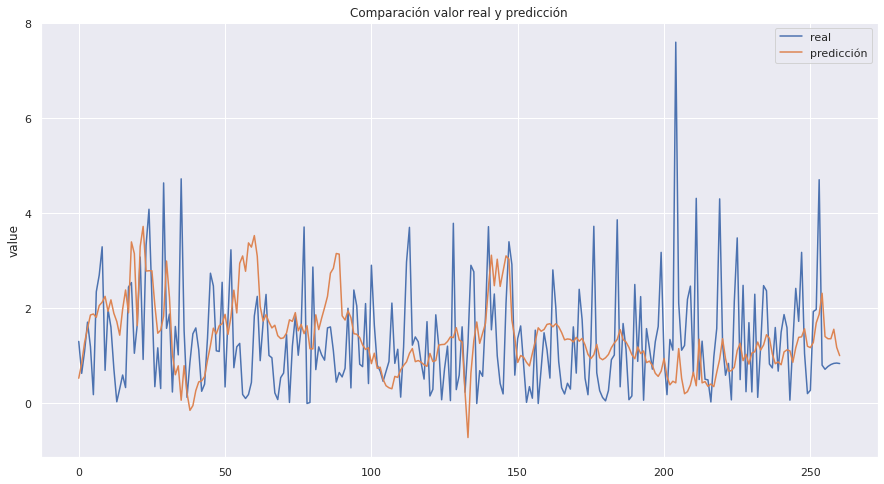

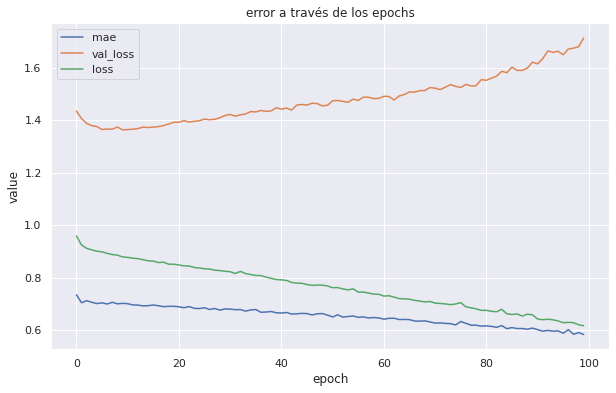

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.282998274006576
MAE is : 0.7986152555404469
RMSE is : 1.132695137275064
MAPE is : 39.025467883312444
Evaluation metric results:
MSE is : 1.9683610707713561
MAE is : 1.0506226867643014
RMSE is : 1.4029829189164622
MAPE is : 52.13463315723893
(627, 15, 5) (627, 1)
(261, 15, 5) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 36ms/step - loss: 0.9498 - mae: 0.7285 - val_loss: 1.4159 - val_mae: 0.7794
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9200 - mae: 0.7048 - val_loss: 1.3923 - val_mae: 0.7701
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9076 - mae: 0.7131 - val_loss: 1.3815 - val_mae: 0.7742
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9036 - mae: 0.7060 - val_loss: 1.3815 - val_mae: 0.7740
Epoch 5/100
32/32 [==============================] - 1s 16ms/step - loss: 0.8969 - mae: 0.7036 - v

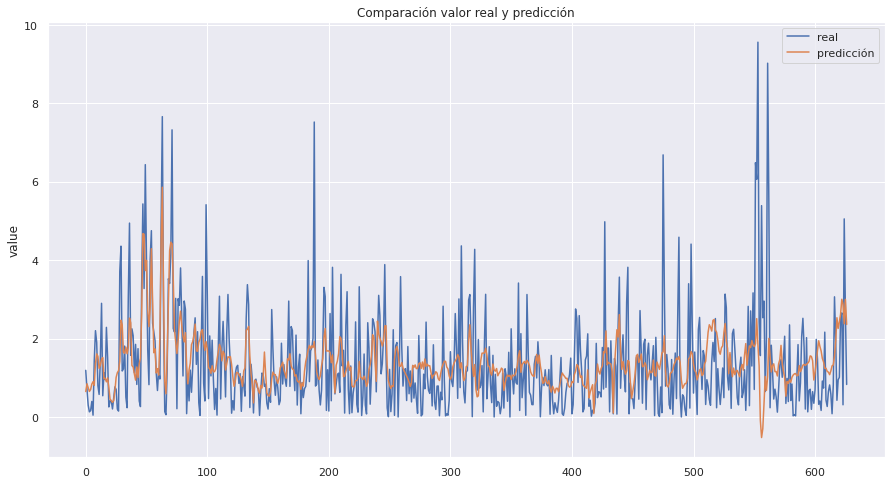

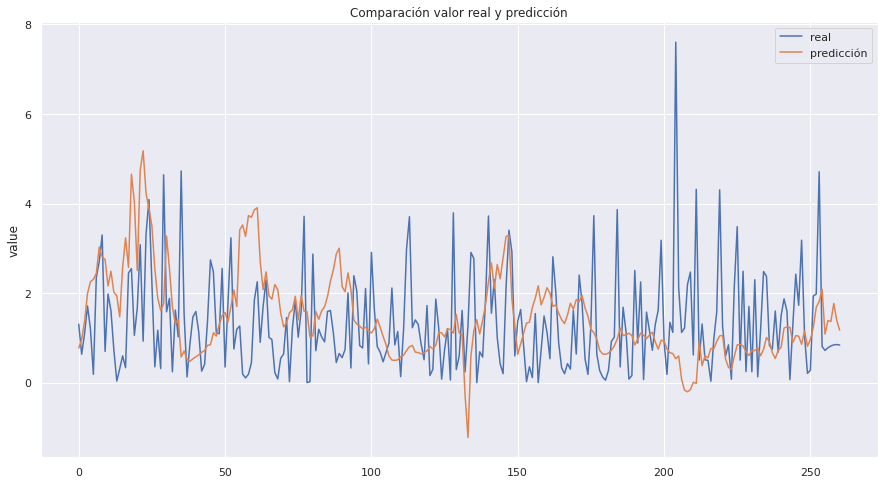

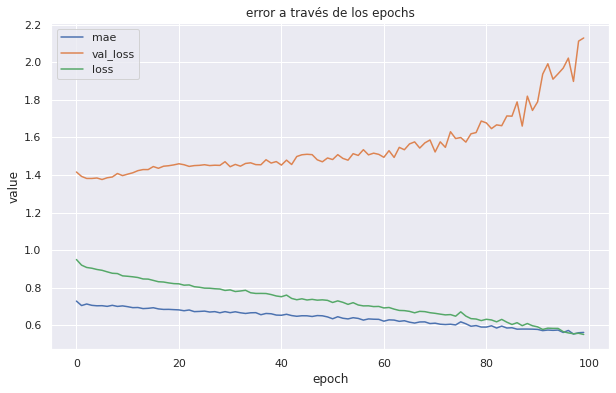

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.3311463173764144
MAE is : 0.8053348021588165
RMSE is : 1.1537531440374993
MAPE is : 39.13839713294182
Evaluation metric results:
MSE is : 2.173703821083622
MAE is : 1.1024841108588015
RMSE is : 1.474348609075758
MAPE is : 52.8194909275056
(627, 15, 5) (627, 1)
(261, 15, 5) (261, 1)
Epoch 1/100
32/32 [==============================] - 3s 41ms/step - loss: 0.9634 - mae: 0.7361 - val_loss: 1.3912 - val_mae: 0.7785
Epoch 2/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9240 - mae: 0.7061 - val_loss: 1.3787 - val_mae: 0.7684
Epoch 3/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9065 - mae: 0.7114 - val_loss: 1.3710 - val_mae: 0.7742
Epoch 4/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9014 - mae: 0.7068 - val_loss: 1.3785 - val_mae: 0.7731
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.8943 - mae: 0.7031 - val

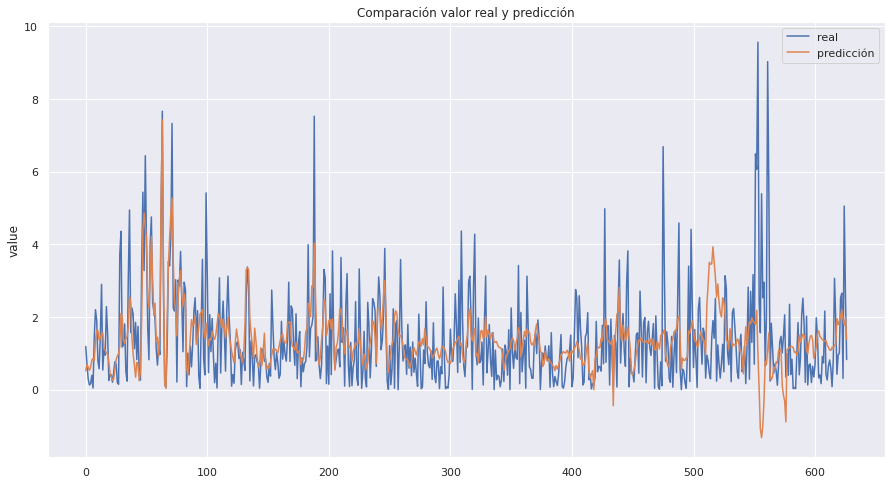

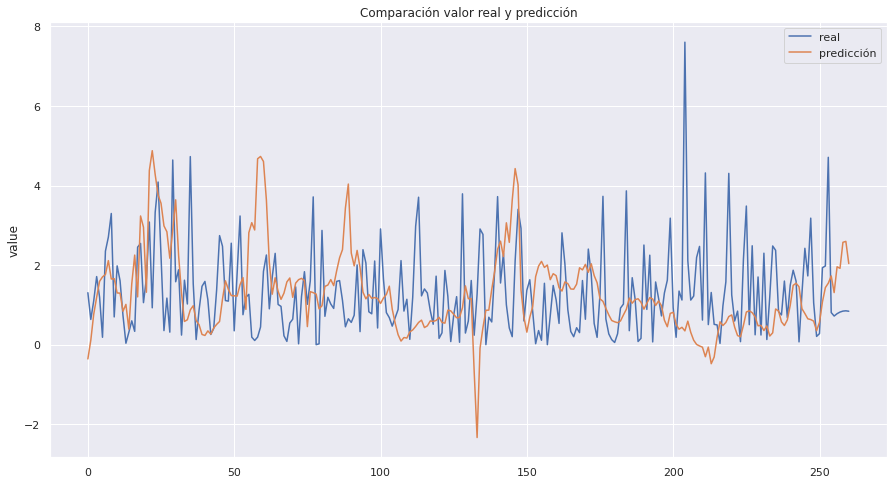

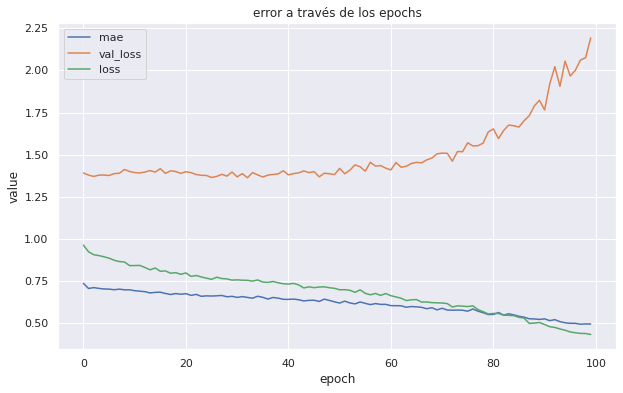

9/9 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 1.1774926475433847
MAE is : 0.734226014991149
RMSE is : 1.085123332872068
MAPE is : 36.55159340925147
Evaluation metric results:
MSE is : 2.114890718110149
MAE is : 1.068353082765511
RMSE is : 1.4542663848518775
MAPE is : 49.280028163505726
(627, 15, 5) (627, 1)
(261, 15, 5) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 80ms/step - loss: 0.9809 - mae: 0.7434 - val_loss: 1.3892 - val_mae: 0.7815
Epoch 2/100
32/32 [==============================] - 2s 57ms/step - loss: 0.9246 - mae: 0.7085 - val_loss: 1.3871 - val_mae: 0.7726
Epoch 3/100
32/32 [==============================] - 2s 55ms/step - loss: 0.9075 - mae: 0.7148 - val_loss: 1.3854 - val_mae: 0.7732
Epoch 4/100
32/32 [==============================] - 2s 57ms/step - loss: 0.8986 - mae: 0.7064 - val_loss: 1.3856 - val_mae: 0.7697
Epoch 5/100
32/32 [==============================] - 2s 58ms/step - loss: 0.8864 - mae: 0.7021 - va

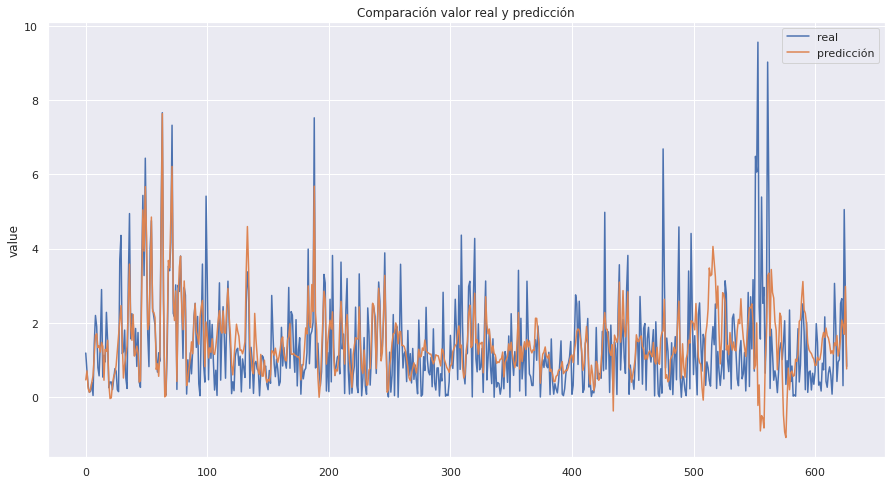

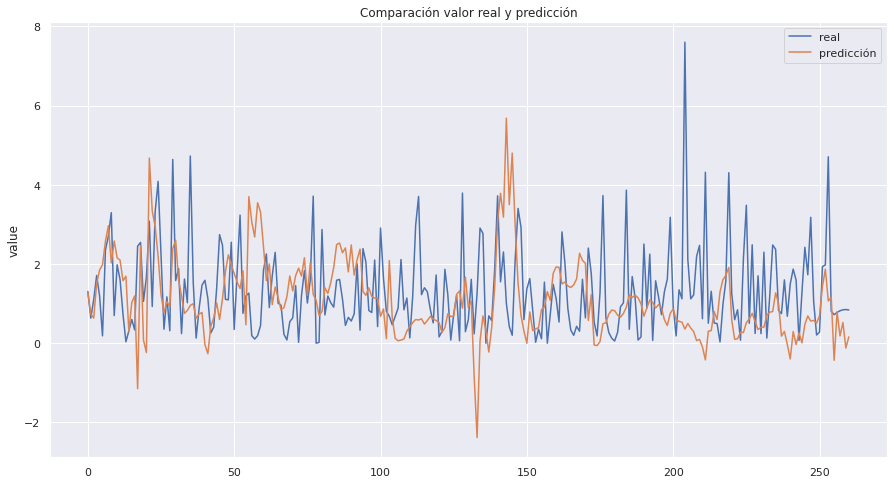

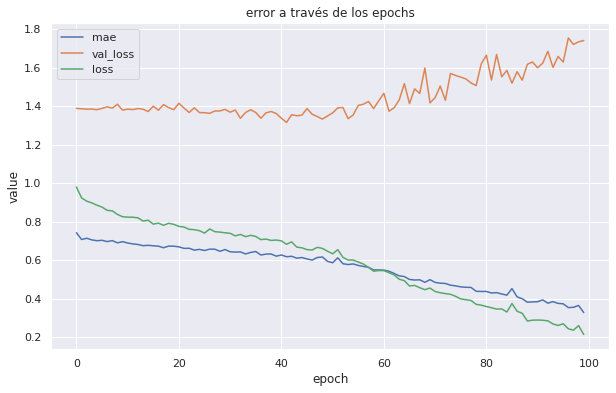

9/9 [==============================] - 0s 29ms/step
Evaluation metric results:
MSE is : 0.762344719119307
MAE is : 0.5196909143466905
RMSE is : 0.8731235417278056
MAPE is : 25.78402128554651
Evaluation metric results:
MSE is : 2.208283309498388
MAE is : 1.1297739320974356
RMSE is : 1.486029377064393
MAPE is : 52.93795595601488


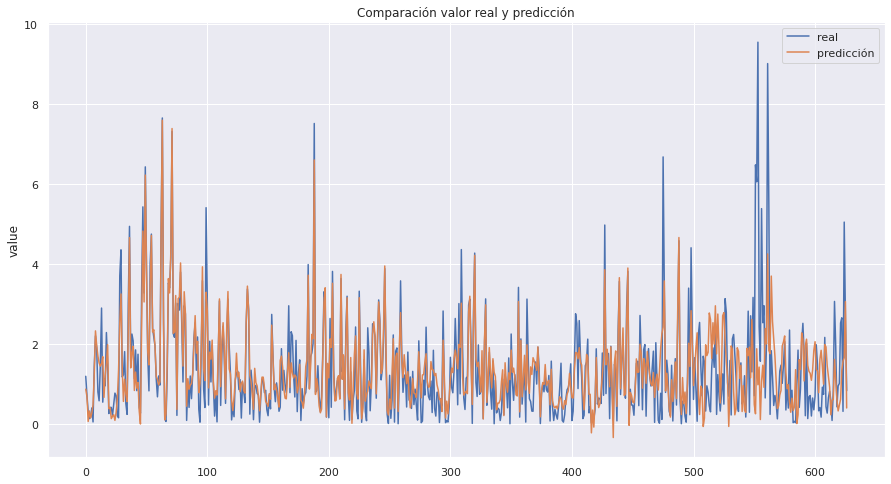

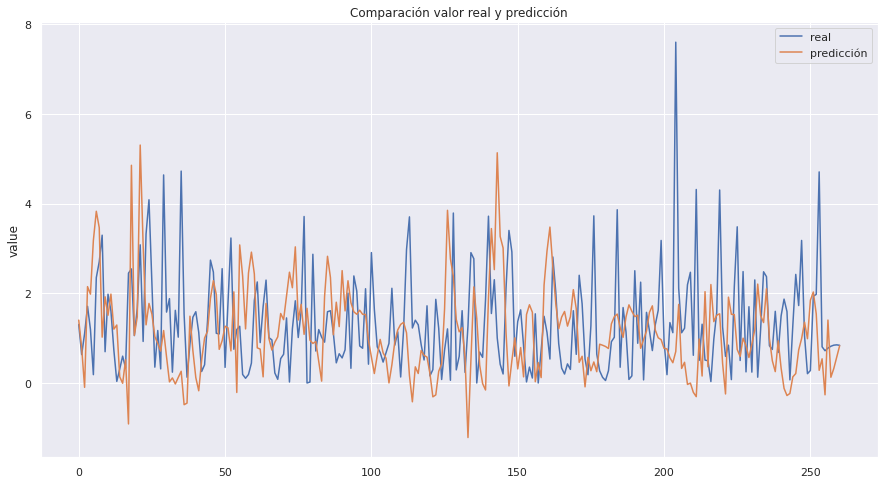

In [12]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=5,epochss=100,batch_sizze=16,lag=lg)